<a href="https://colab.research.google.com/github/martaarozarena/KSchool-Master-Final-Project/blob/master/Testing_different_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pmdarima

     |████████████████████████████████| 1.5MB 1.4MB/s 
     |████████████████████████████████| 2.1MB 7.1MB/s 
     |████████████████████████████████| 8.7MB 14.8MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from google.colab import drive

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/KSchool-Master-Final-Project'       # path to your project on Drive

drive.mount(ROOT)           # we mount the drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import pmdarima as pm
pm.__version__

'1.6.1'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import math
import itertools
import datetime
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error

In [4]:
%pwd

'/content'

In [5]:
%cd drive/My Drive/KSchool-Master-Final-Project

/content/drive/My Drive/KSchool-Master-Final-Project


In [3]:
covid = pd.read_csv('./data/owid-covid-data 20200713.csv', parse_dates=["date"])

covid_eur = covid[covid['continent']=='Europe']

covid_esp = covid_eur[covid_eur["location"]=="Spain"].reset_index()

#indexes = covid_esp[(covid_esp["new_cases"]<0) &(covid_esp["location"]=="Spain")].index.values
#sustituir por la media de valores anterior y posterior
#for i in indexes:
#  covid_esp.iloc[i,6]= (covid_esp.iloc[i+1,6]+covid_esp.iloc[i-1,6])/2

covid_esp.index = covid_esp.date
covid_esp_newcases = covid_esp["new_cases"]
covid_esp_newcases = covid_esp_newcases.resample('D').sum()

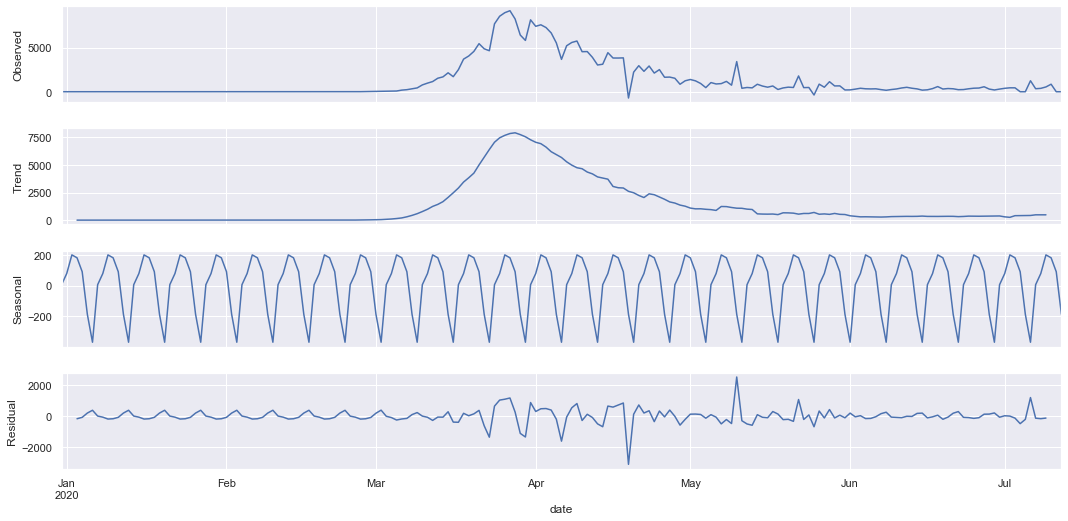

In [4]:
res = sm.tsa.seasonal_decompose(covid_esp_newcases)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

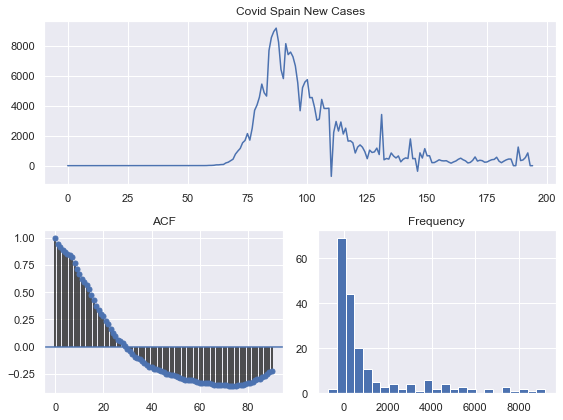

In [5]:
pm.tsdisplay(covid_esp_newcases, lag_max=90, title="Covid Spain New Cases", show=True)

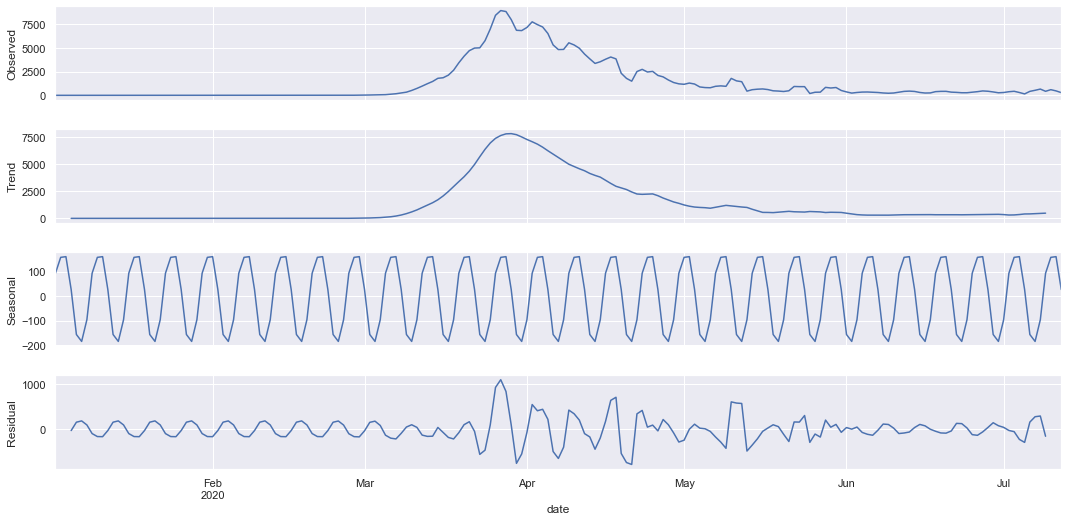

In [6]:
covid_esp_smooth3 = covid_esp_newcases.rolling(3).mean()

res = sm.tsa.seasonal_decompose(covid_esp_smooth3.dropna())
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

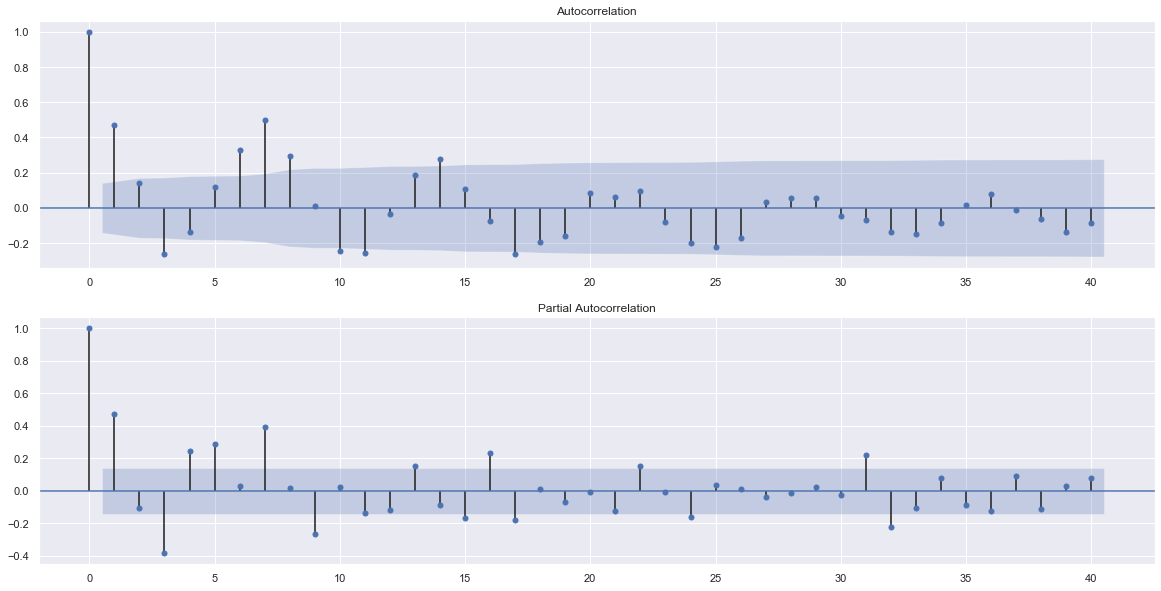

In [7]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(covid_esp_smooth3.diff().dropna(), lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(covid_esp_smooth3.diff().dropna(), lags=40, ax=ax[1])
plt.show()

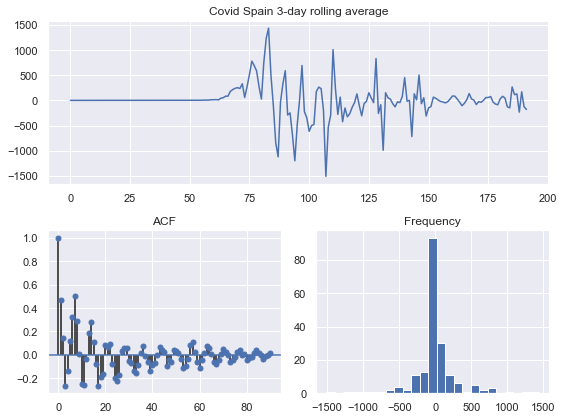

In [8]:
pm.tsdisplay(covid_esp_smooth3.diff().dropna(), lag_max=90, title="Covid Spain 3-day rolling average", show=True)

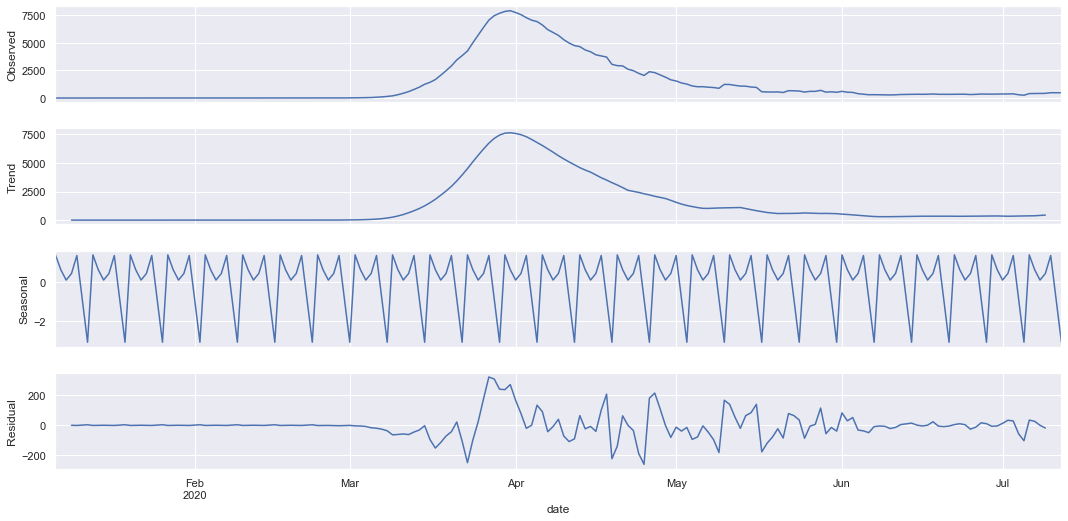

In [9]:
covid_esp_smooth7 = covid_esp_newcases.rolling(7).mean()

res = sm.tsa.seasonal_decompose(covid_esp_smooth7.dropna())
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

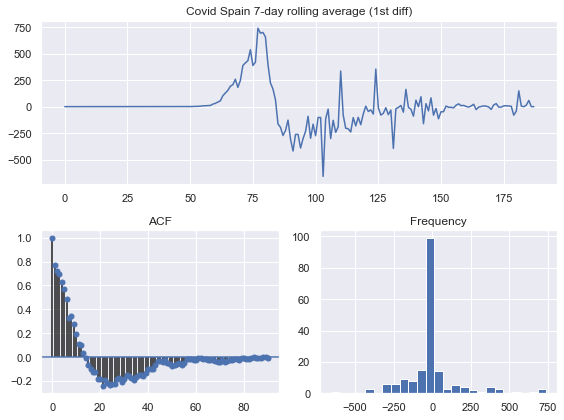

In [10]:
pm.tsdisplay(covid_esp_smooth7.diff().dropna(), lag_max=90, title="Covid Spain 7-day rolling average (1st diff)", show=True)

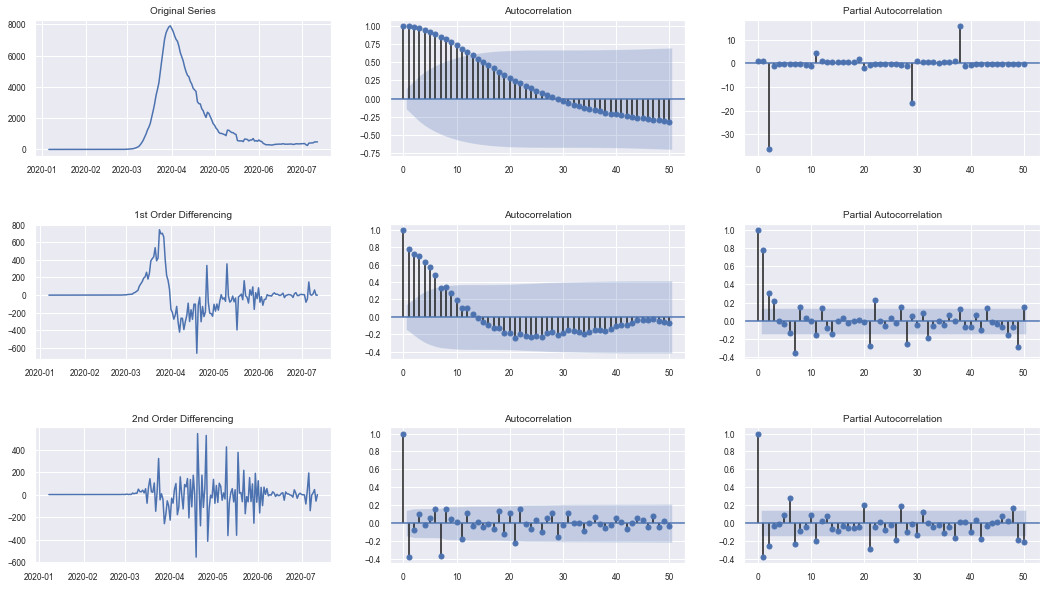

<function seaborn.rcmod.reset_defaults()>

In [11]:
# Original Series
plt.rcParams.update({'figure.figsize':(18,10), 'figure.subplot.hspace':0.5,
                     'xtick.labelsize':'x-small', 'ytick.labelsize':'x-small', 'axes.titlesize':'small'})
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(covid_esp_smooth7); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(covid_esp_smooth7.dropna(), lags=50, ax=axes[0, 1])
sm.graphics.tsa.plot_pacf(covid_esp_smooth7.dropna(), lags=50, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(covid_esp_smooth7.diff()); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(covid_esp_smooth7.diff().dropna(), lags=50, ax=axes[1, 1])
sm.graphics.tsa.plot_pacf(covid_esp_smooth7.diff().dropna(), lags=50, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(covid_esp_smooth7.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(covid_esp_smooth7.diff().diff().dropna(), lags=50, ax=axes[2, 1])
sm.graphics.tsa.plot_pacf(covid_esp_smooth7.diff().diff().dropna(), lags=50, ax=axes[2, 2])
plt.show()
sns.reset_defaults

In [12]:
from pmdarima.arima.utils import ndiffs

## Adf Test
print('ADF: ', ndiffs(covid_esp_smooth7.dropna(), test='adf'))

# KPSS test
print('KPSS: ', ndiffs(covid_esp_smooth7.dropna(), test='kpss'))

# PP test:
print('PP: ', ndiffs(covid_esp_smooth7.dropna(), test='pp'))


ADF:  2
KPSS:  1
PP:  1


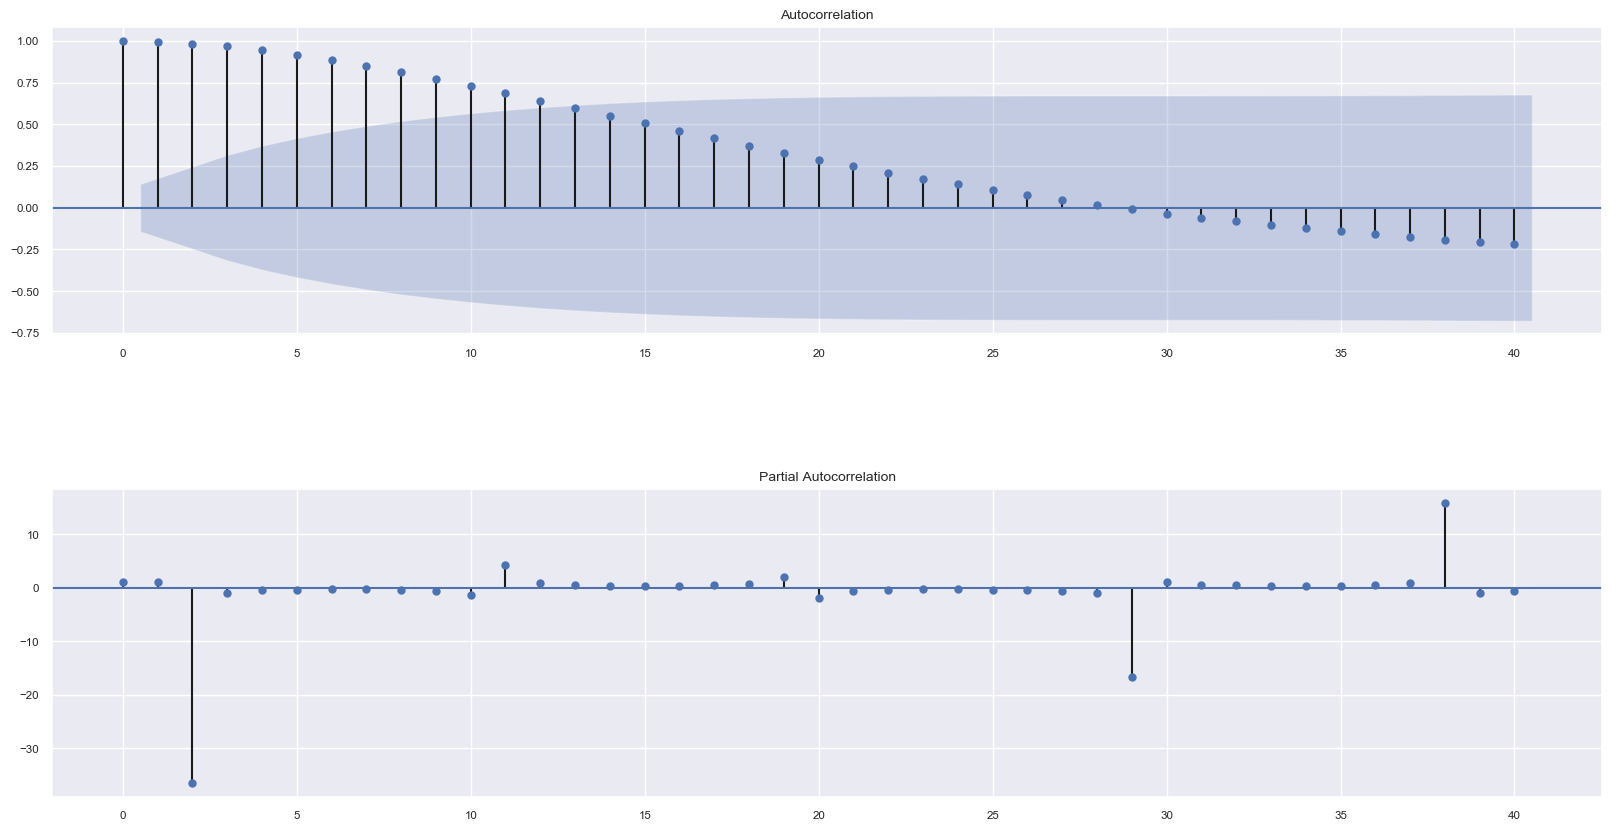

In [43]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(covid_esp_smooth7.dropna(), lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(covid_esp_smooth7.dropna(), lags=40, ax=ax[1])
plt.show()

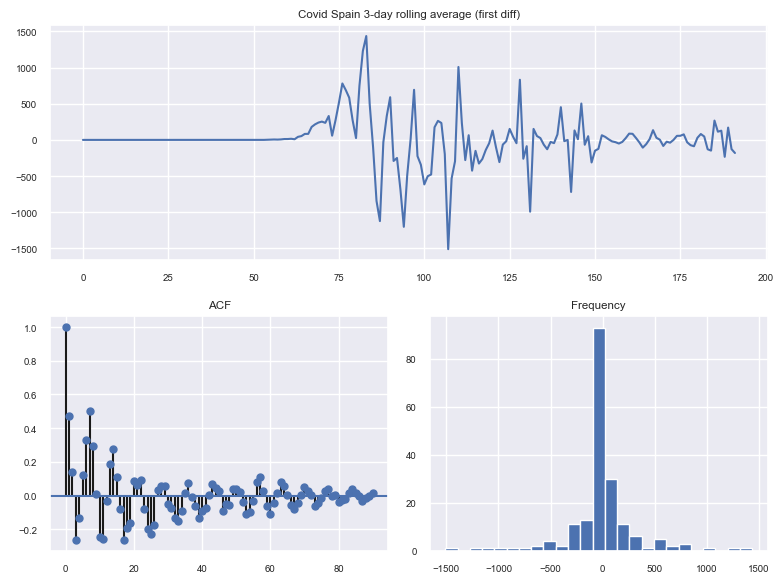

In [35]:
pm.tsdisplay(covid_esp_smooth3.diff().dropna(), lag_max=90, title="Covid Spain 3-day rolling average (first diff)", show=True)

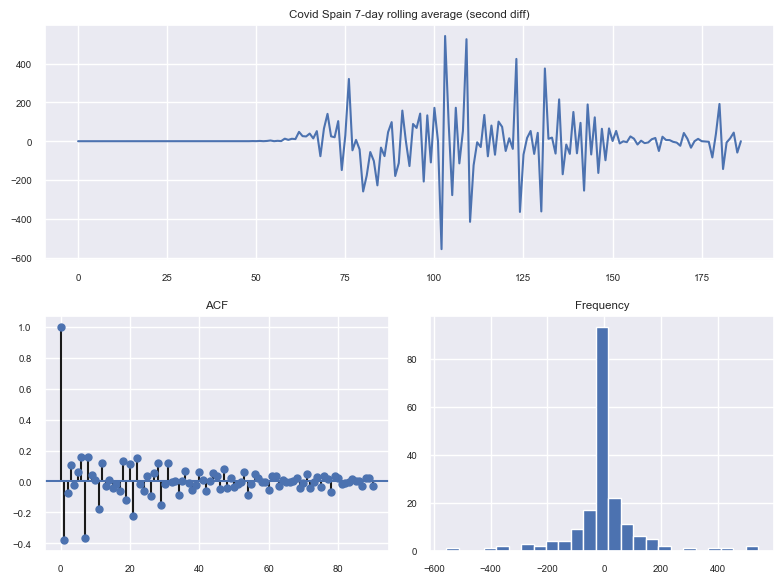

In [36]:
pm.tsdisplay(covid_esp_smooth7.diff().diff().dropna(), lag_max=90, title="Covid Spain 7-day rolling average (second diff)", show=True)

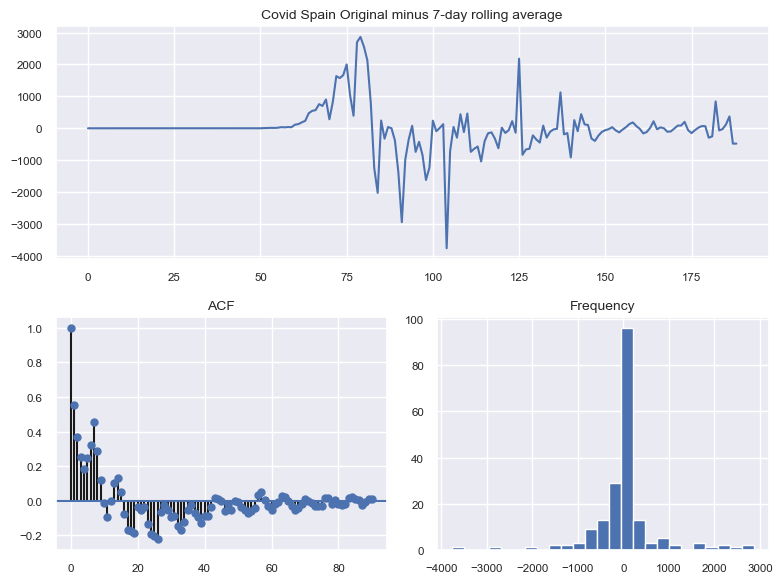

In [45]:
pm.tsdisplay((covid_esp_newcases-covid_esp_smooth7).dropna(), lag_max=90, title="Covid Spain Original minus 7-day rolling average", show=True)

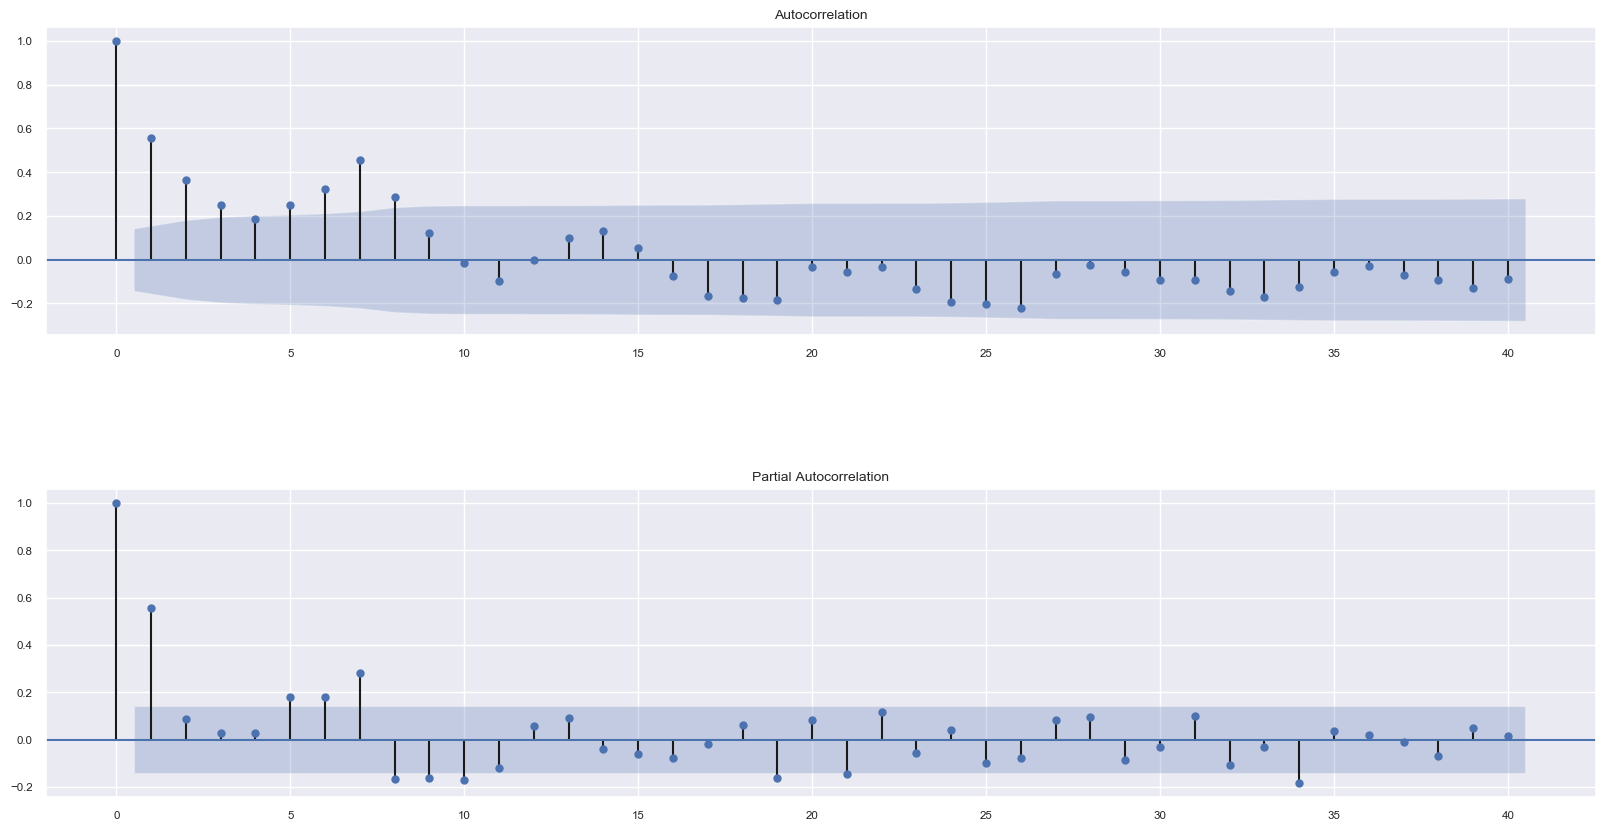

In [46]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf((covid_esp_newcases-covid_esp_smooth7).dropna(), lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf((covid_esp_newcases-covid_esp_smooth7).dropna(), lags=40, ax=ax[1])
plt.show()

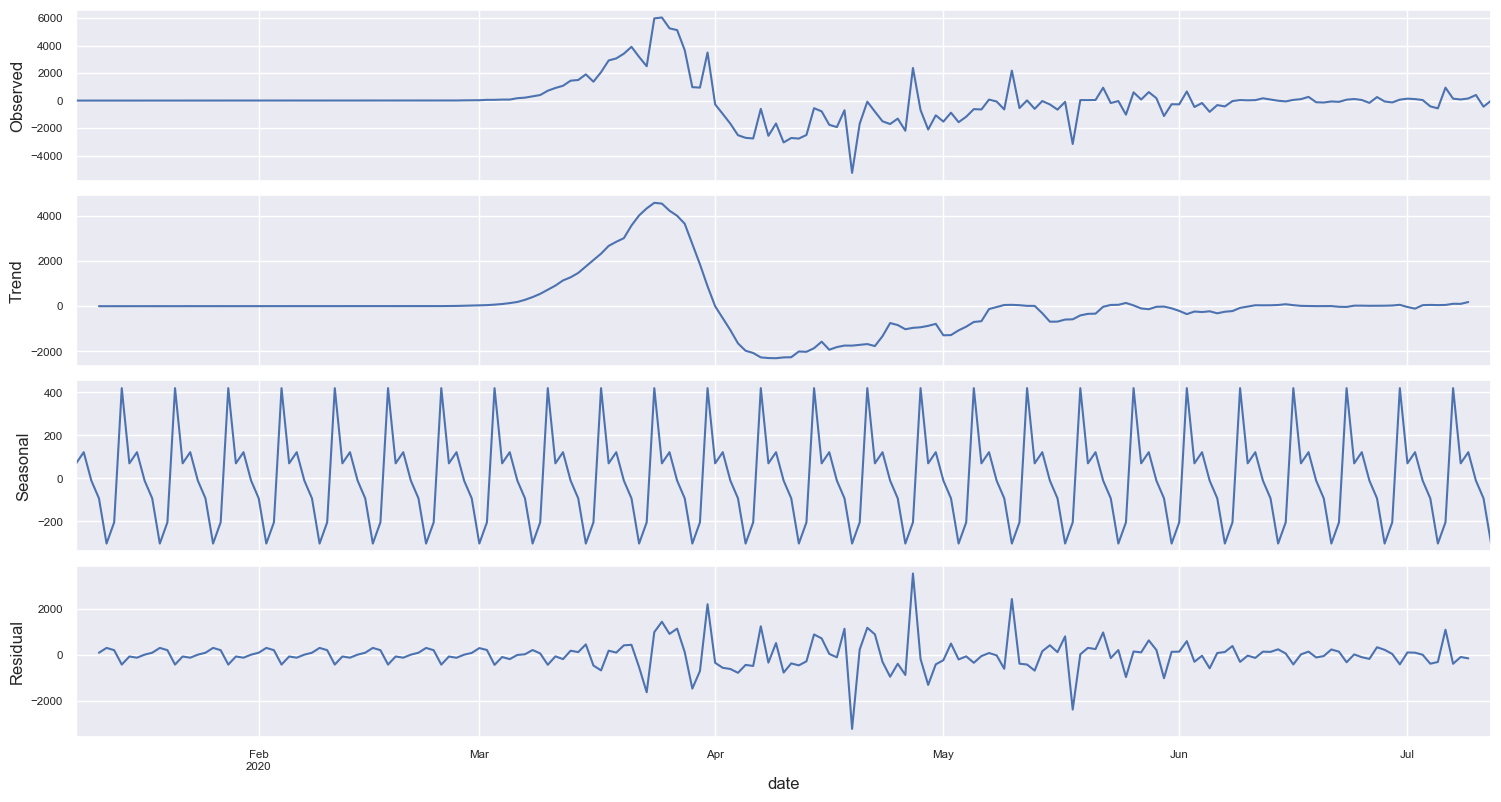

In [48]:
covid_esp_diff8 = covid_esp_newcases.diff(8)

res = sm.tsa.seasonal_decompose(covid_esp_diff8.dropna())
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

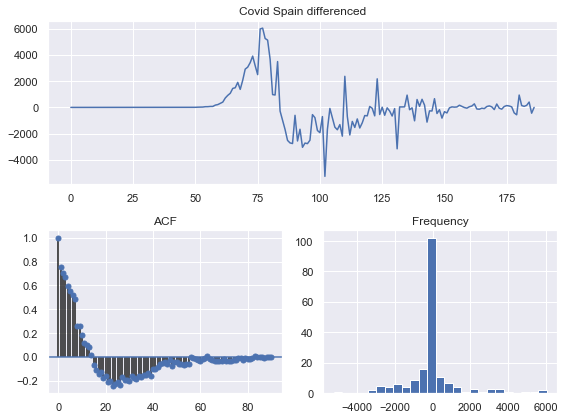

In [16]:
pm.tsdisplay(covid_esp_diff8[8:], lag_max=90, title="Covid Spain differenced", show=True)

In [49]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=3).mean()
    rolling_std = timeseries.rolling(window=3).std()

    # Plot rolling statistics

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Result of Dicky=Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

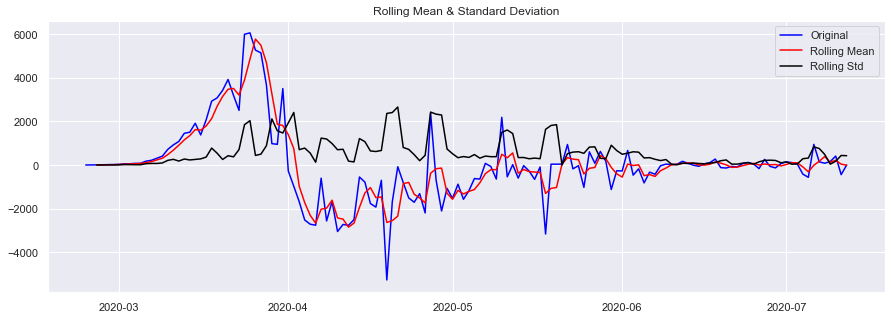

Result of Dicky=Fuller Test
Test Statistic           -3.402735
p-value                   0.010866
#Lags Used                7.000000
#Observations Used      132.000000
Critical Value (1%)      -3.480888
Critical Value (5%)      -2.883697
Critical Value (10%)     -2.578586
dtype: float64


In [13]:
test_stationarity(covid_esp_newcases.diff(8)['2020-02-24':])

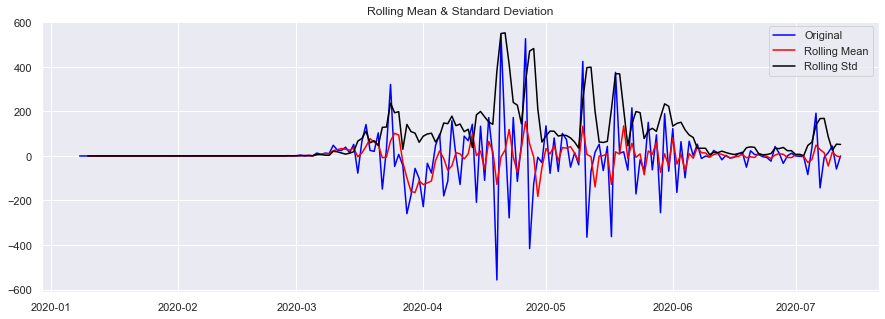

Result of Dicky=Fuller Test
Test Statistic           -4.785547
p-value                   0.000058
#Lags Used               10.000000
#Observations Used      176.000000
Critical Value (1%)      -3.468062
Critical Value (5%)      -2.878106
Critical Value (10%)     -2.575602
dtype: float64


In [12]:
test_stationarity(covid_esp_smooth7.diff().diff().dropna())

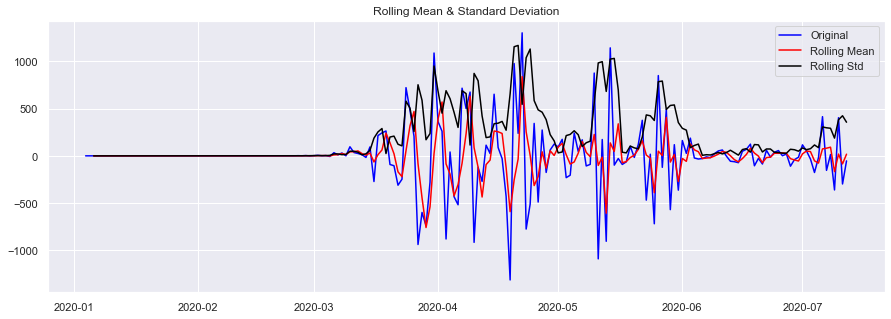

Result of Dicky=Fuller Test
Test Statistic           -4.862810
p-value                   0.000041
#Lags Used               14.000000
#Observations Used      176.000000
Critical Value (1%)      -3.468062
Critical Value (5%)      -2.878106
Critical Value (10%)     -2.575602
dtype: float64


In [18]:
test_stationarity(covid_esp_smooth3.diff().diff().dropna())

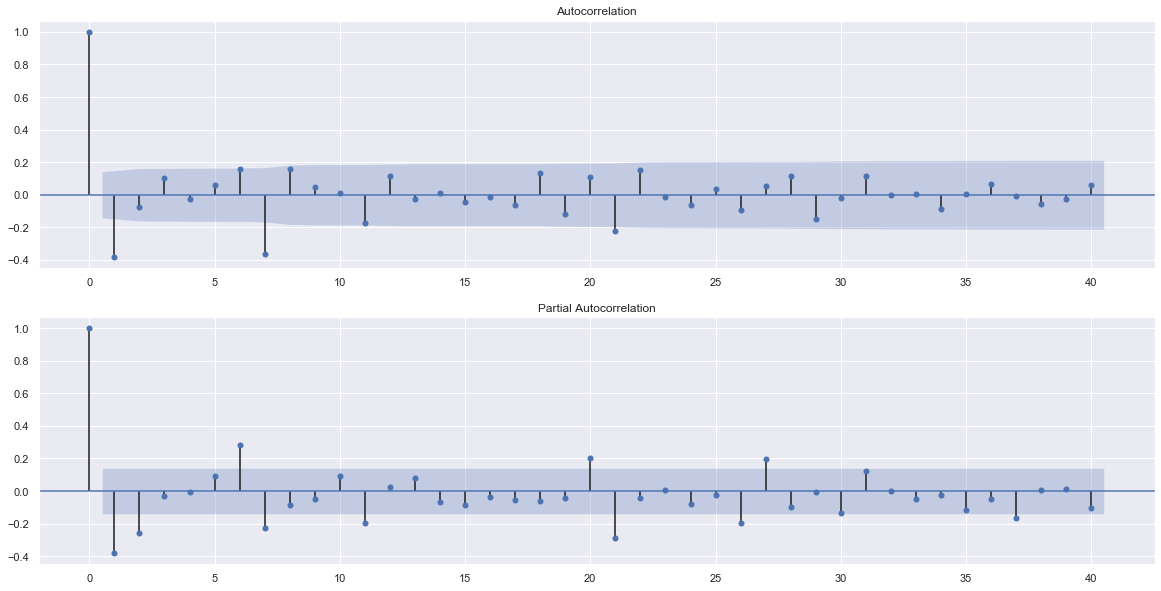

In [39]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(covid_esp_smooth7.diff().diff().dropna(), lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(covid_esp_smooth7.diff().diff().dropna(), lags=40, ax=ax[1])
plt.show()

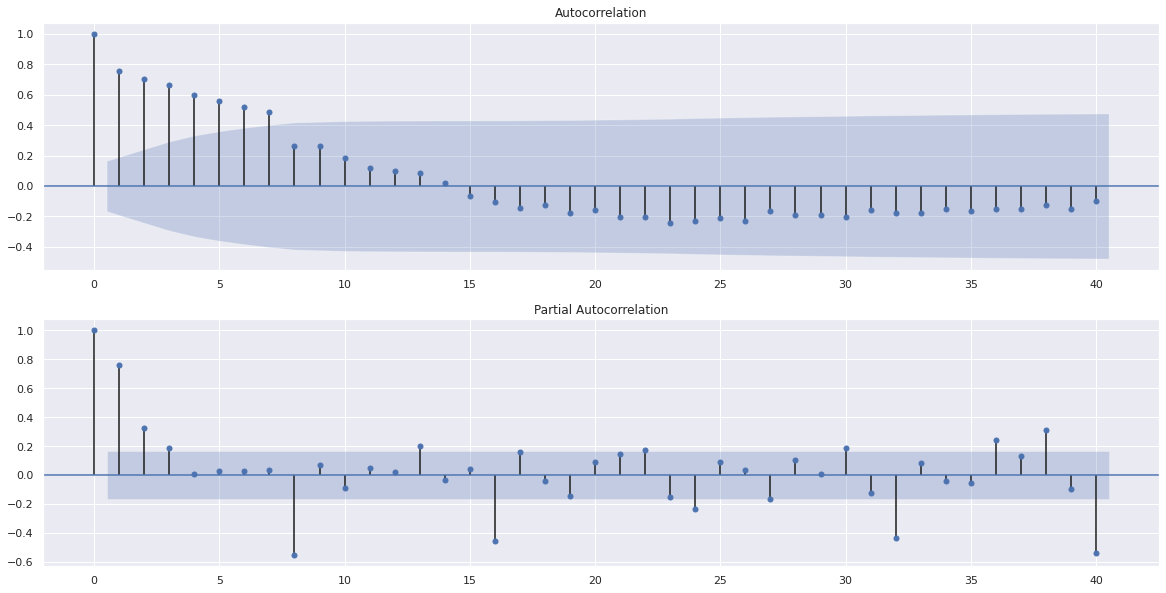

In [13]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(covid_esp_newcases.diff(8)['2020-02-24':], lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(covid_esp_newcases.diff(8)['2020-02-24':], lags=40, ax=ax[1])
plt.show()

In [ ]:
#resDiff = sm.tsa.arma_order_select_ic(covid_esp_newcases, max_ar=8, max_ma=8, ic='aic', trend='c')
#print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [ ]:
# Grid Search
p = d = q = range(0,9) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q
combs = {} # stores aic and order pairs
aics = [] # stores aics
# Grid Search continued
for combination in pdq:
    try:
        model = ARIMA(covid_esp_diff8.dropna(), order=combination) # create all possible models
        model = model.fit()
        combs.update({model.aic : combination}) # store combinations
        aics.append(model.aic)
    except:
        continue
        
best_aic = min(aics)

In [ ]:
combs[best_aic]

(8, 0, 7)

In [27]:
# Grid Search
p = d = q = range(0,9) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q
combs = {} # stores aic and order pairs
aics = [] # stores aics
# Grid Search continued
for combination in pdq:
    try:
        model = ARIMA(covid_esp_smooth7.dropna(), order=combination) # create all possible models
        model = model.fit()
        combs.update({model.aic : combination}) # store combinations
        aics.append(model.aic)
    except:
        continue
        
best_aic = min(aics)

In [28]:
best_aic

2257.9260794151746

In [29]:
combs[best_aic]

(6, 2, 7)

In [17]:
# Model Creation and Forecasting. From the code above we get best_aic=2992.5536173498153 and order=(8, 0, 7)
#model = ARIMA(covid_esp_diff8.dropna(), order=combs[best_aic])

from statsmodels.tsa.arima_model import ARIMA

best_order=(8, 0, 7)
model = ARIMA(covid_esp_diff8.dropna(), order=best_order)
model = model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


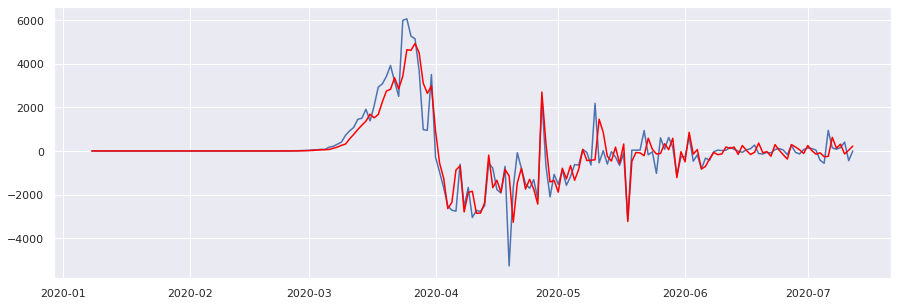

In [18]:
plt.plot(covid_esp_diff8)
plt.plot(model.fittedvalues, color='red')
plt.show()

In [126]:
covid_esp_diff8_fc = model.forecast(16)[0]
covid_esp_diff8_fc_s = pd.Series(covid_esp_diff8_fc)

In [53]:
covid_esp_diff8.shape

(195,)

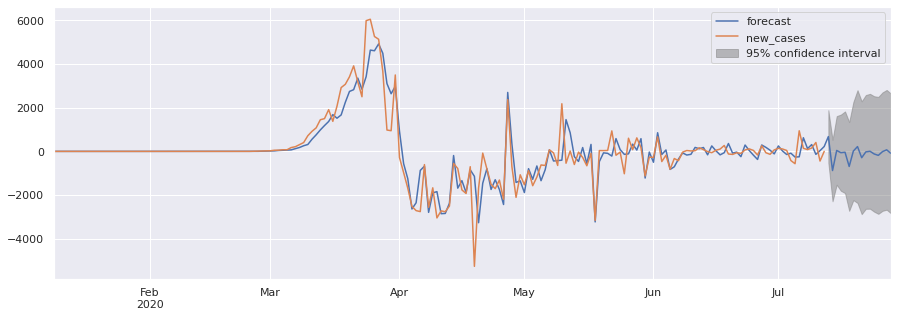

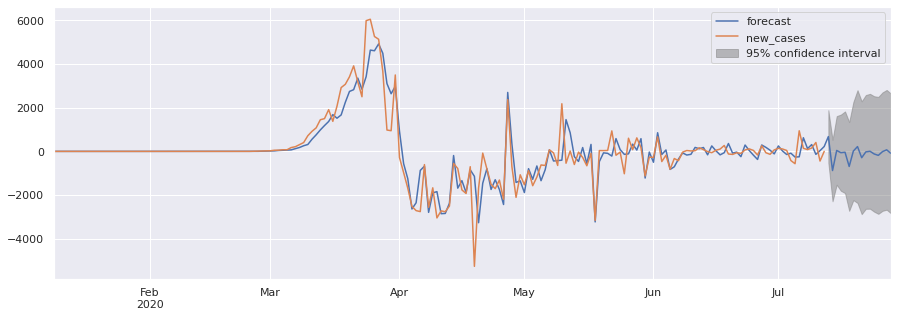

In [21]:
model.plot_predict(1,202)

In [86]:
periods = 8

restored = covid_esp_newcases.copy()
restored.iloc[periods:] = np.nan
for d, val in covid_esp_diff8.iloc[periods:].iteritems():
    restored.loc[d] = restored.loc[d - pd.DateOffset(days=periods)] + val

res = pd.concat([covid_esp_newcases, covid_esp_diff8, restored], axis=1)
res.columns = ['original', 'diffs', 'restored']
res.tail(15)

,original,diffs,restored
date,,,
2020-06-28,301.0,-62.0,301.0
2020-06-29,200.0,-134.0,200.0
2020-06-30,301.0,69.0,301.0
2020-07-01,388.0,140.0,388.0
2020-07-02,444.0,110.0,444.0
2020-07-03,442.0,42.0,442.0
2020-07-04,0.0,-419.0,0.0
2020-07-05,0.0,-564.0,0.0
2020-07-06,1244.0,943.0,1244.0


In [67]:
covid_esp_diff8_fc_s

0     678.335128
1    -876.183583
2      43.437697
3     -59.159018
4     -39.245726
5    -689.773963
6      14.651657
7     220.454064
8    -289.496447
9     -23.033341
10      5.804812
11   -117.475497
12   -182.205924
13    -10.398784
14     71.954093
15    -89.333704
dtype: float64

In [81]:
covid_esp_diff8_fc_s.index

DatetimeIndex(['2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28'],
              dtype='datetime64[ns]', freq=None)

In [127]:
import datetime


covid_esp_diff8_fc_s.index = [covid_esp_diff8.index[-1] + datetime.timedelta(days=1), covid_esp_diff8.index[-1] + datetime.timedelta(days=2), 
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=3), covid_esp_diff8.index[-1] + datetime.timedelta(days=4),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=5), covid_esp_diff8.index[-1] + datetime.timedelta(days=6),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=7), covid_esp_diff8.index[-1] + datetime.timedelta(days=8),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=9), covid_esp_diff8.index[-1] + datetime.timedelta(days=10),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=11), covid_esp_diff8.index[-1] + datetime.timedelta(days=12),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=13), covid_esp_diff8.index[-1] + datetime.timedelta(days=14),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=15), covid_esp_diff8.index[-1] + datetime.timedelta(days=16)]

#for i in range(0, 17):
#  datetime.datetime.fromtimestamp(covid_esp_diff8_fc_s.index[i])

covid_esp_diff8_fc_s

2020-07-13    678.335128
2020-07-14   -876.183583
2020-07-15     43.437697
2020-07-16    -59.159018
2020-07-17    -39.245726
2020-07-18   -689.773963
2020-07-19     14.651657
2020-07-20    220.454064
2020-07-21   -289.496447
2020-07-22    -23.033341
2020-07-23      5.804812
2020-07-24   -117.475497
2020-07-25   -182.205924
2020-07-26    -10.398784
2020-07-27     71.954093
2020-07-28    -89.333704
dtype: float64

In [105]:
covid_esp_diff8.index[-1]

Timestamp('2020-07-12 00:00:00', freq='D')

In [106]:
covid_esp_diff8_fc_s.index[0]

Timestamp('2020-07-13 00:00:00', freq='D')

In [128]:
covid_esp_diff8_fc_s = covid_esp_diff8_fc_s.resample('D').sum()

In [129]:
covid_esp_diff8_fc_s

2020-07-13    678.335128
2020-07-14   -876.183583
2020-07-15     43.437697
2020-07-16    -59.159018
2020-07-17    -39.245726
2020-07-18   -689.773963
2020-07-19     14.651657
2020-07-20    220.454064
2020-07-21   -289.496447
2020-07-22    -23.033341
2020-07-23      5.804812
2020-07-24   -117.475497
2020-07-25   -182.205924
2020-07-26    -10.398784
2020-07-27     71.954093
2020-07-28    -89.333704
Freq: D, dtype: float64

In [130]:
covid_esp_diff8plusfc = covid_esp_diff8.append(covid_esp_diff8_fc_s)

In [131]:
covid_esp_diff8plusfc.tail(20)

2020-07-09    155.000000
2020-07-10    408.000000
2020-07-11   -442.000000
2020-07-12      0.000000
2020-07-13    678.335128
2020-07-14   -876.183583
2020-07-15     43.437697
2020-07-16    -59.159018
2020-07-17    -39.245726
2020-07-18   -689.773963
2020-07-19     14.651657
2020-07-20    220.454064
2020-07-21   -289.496447
2020-07-22    -23.033341
2020-07-23      5.804812
2020-07-24   -117.475497
2020-07-25   -182.205924
2020-07-26    -10.398784
2020-07-27     71.954093
2020-07-28    -89.333704
Freq: D, dtype: float64

In [138]:
periods = 8

res_cov_es_fc = covid_esp_diff8plusfc.copy()
#res_cov_es_fc.iloc[periods:] = np.nan
for d, val in covid_esp_diff8plusfc.iloc[periods:].iteritems():
    res_cov_es_fc.loc[d] = covid_esp_diff8plusfc.loc[d - pd.DateOffset(days=periods)] + val

In [137]:
val

-89.33370397456207

In [139]:
res_cov_es_fc.tail(20)

2020-07-09    295.000000
2020-07-10    518.000000
2020-07-11   -400.000000
2020-07-12   -419.000000
2020-07-13    114.335128
2020-07-14     66.816417
2020-07-15    184.437697
2020-07-16     22.840982
2020-07-17    115.754274
2020-07-18   -281.773963
2020-07-19   -427.348343
2020-07-20    220.454064
2020-07-21    388.838681
2020-07-22   -899.216924
2020-07-23     49.242510
2020-07-24   -176.634515
2020-07-25   -221.451650
2020-07-26   -700.172747
2020-07-27     86.605750
2020-07-28    131.120360
Freq: D, dtype: float64

In [143]:
covid_esp_newcases.tail(10)

date
2020-07-03     442.0
2020-07-04       0.0
2020-07-05       0.0
2020-07-06    1244.0
2020-07-07     341.0
2020-07-08     383.0
2020-07-09     543.0
2020-07-10     852.0
2020-07-11       0.0
2020-07-12       0.0
Freq: D, Name: new_cases, dtype: float64

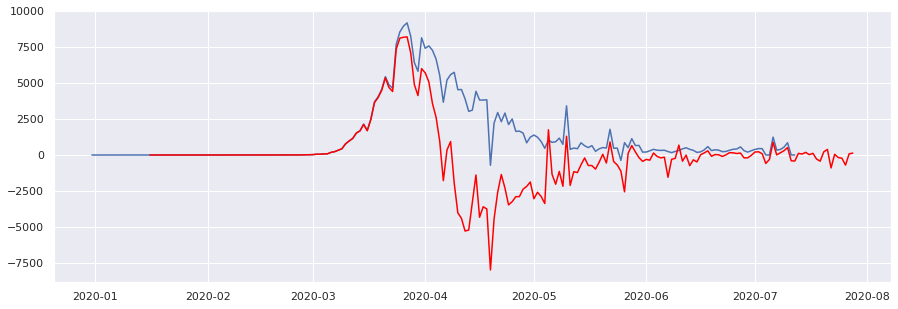

In [144]:
plt.plot(covid_esp_newcases)
plt.plot(res_cov_es_fc, color='red')
plt.show()

In [55]:
modelauto = pm.auto_arima(covid_esp_smooth3.diff().dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                   #   m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                    #  seasonal=False,   # No Seasonality
                    #  start_P=0, 
                        #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelauto.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=2728.903, BIC=2741.933, Time=0.096 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=2774.037, BIC=2780.552, Time=0.008 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=2727.682, BIC=2737.455, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=2738.731, BIC=2748.503, Time=0.024 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=2772.040, BIC=2775.298, Time=0.000 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=2727.625, BIC=2740.655, Time=0.024 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=2700.447, BIC=2716.735, Time=0.040 seconds
Fit ARIMA(4,0,0)x(0,0,0,0) [intercept=True]; AIC=2690.734, BIC=2710.279, Time=0.112 seconds
Fit ARIMA(5,0,0)x(0,0,0,0) [intercept=True]; AIC=2677.788, BIC=2700.590, Time=0.168 seconds
Fit ARIMA(6,0,0)x(0,0,0,0) [intercept=True]; AIC=2679.714, BIC=2705.774, Time=0.164 seconds
Fit ARIMA(5,0,1)x(0,0,0,0) [intercep

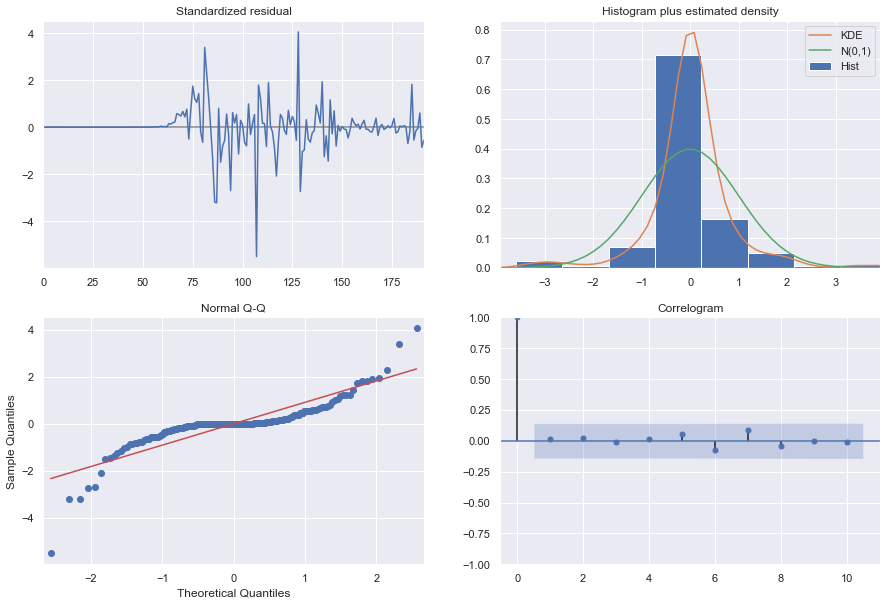

In [27]:
modelauto.plot_diagnostics(figsize=(15,10))
plt.show()

In [58]:
modelauto3 = pm.auto_arima(covid_esp_smooth3.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                     # m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                     # seasonal=False,   # No Seasonality
                     # start_P=0, 
                     # D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelauto3.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2728.881, BIC=2741.911, Time=0.114 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2774.037, BIC=2780.552, Time=0.008 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2727.661, BIC=2737.433, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2738.720, BIC=2748.492, Time=0.024 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2772.041, BIC=2775.298, Time=0.012 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=2727.602, BIC=2740.632, Time=0.016 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=2700.414, BIC=2716.701, Time=0.058 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=2690.696, BIC=2710.241, Time=0.142 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=2677.746, BIC=2700.549, Time=0.151 seconds
Fit ARIMA(6,1,0)x(0,0,0,0) [intercept=True]; AIC=2679.673, BIC=2705.733, Time=0.190 seconds
Fit ARIMA(5,1,1)x(0,0,0,0) [intercep

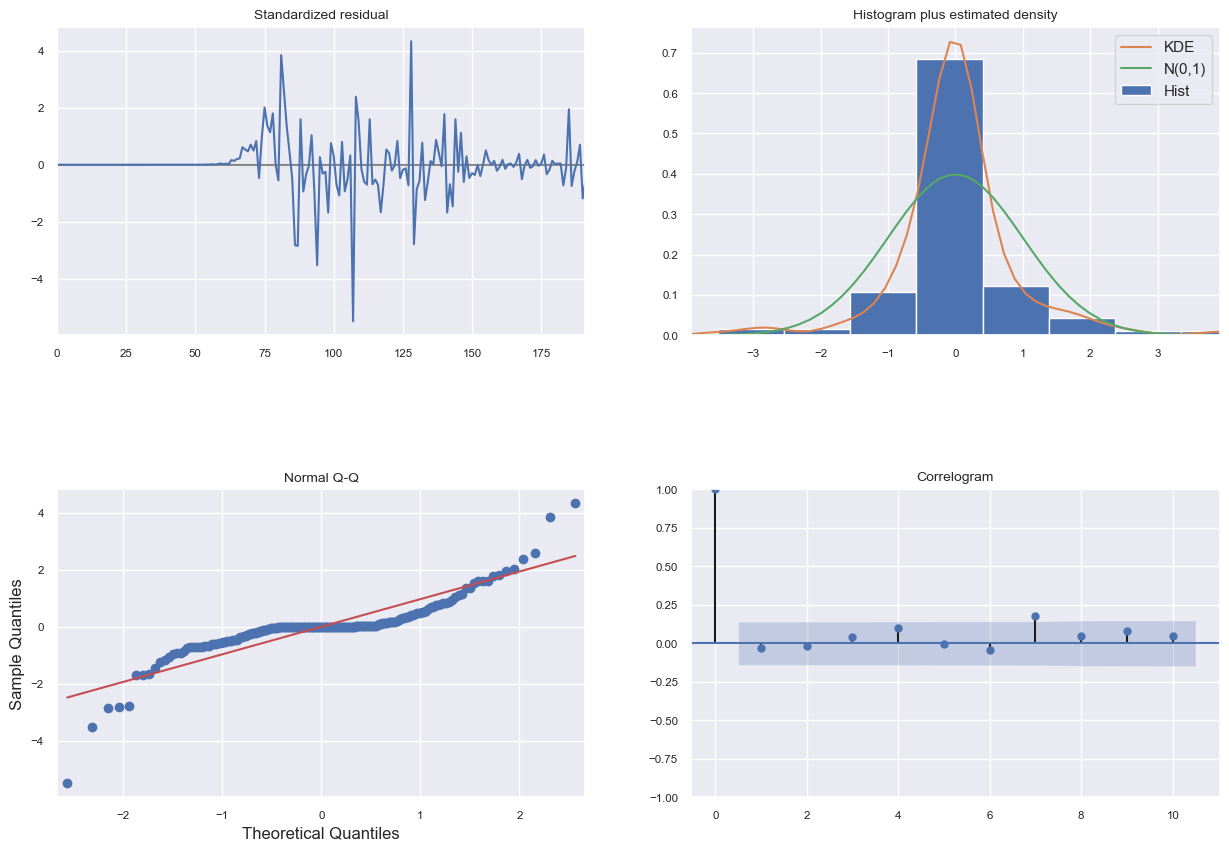

In [59]:
modelauto3.plot_diagnostics(figsize=(15,10))
plt.show()

In [76]:
modelauto7 = pm.auto_arima(covid_esp_smooth7.dropna(), start_p=1, start_q=1,
                    #  test='kpss',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                    #  seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                     # out_of_sample_size=20
                          )

print(modelauto7.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2304.454, BIC=2317.400, Time=0.120 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2493.809, BIC=2500.282, Time=0.008 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2325.113, BIC=2334.822, Time=0.048 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2405.359, BIC=2415.068, Time=0.048 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2491.846, BIC=2495.083, Time=0.008 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=2306.126, BIC=2322.308, Time=0.136 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=2305.805, BIC=2321.987, Time=0.152 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=2378.364, BIC=2391.310, Time=0.072 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=2309.493, BIC=2322.439, Time=0.064 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=2300.231, BIC=2319.650, Time=0.285 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercep

In [77]:
modelauto7.scoring

'mse'

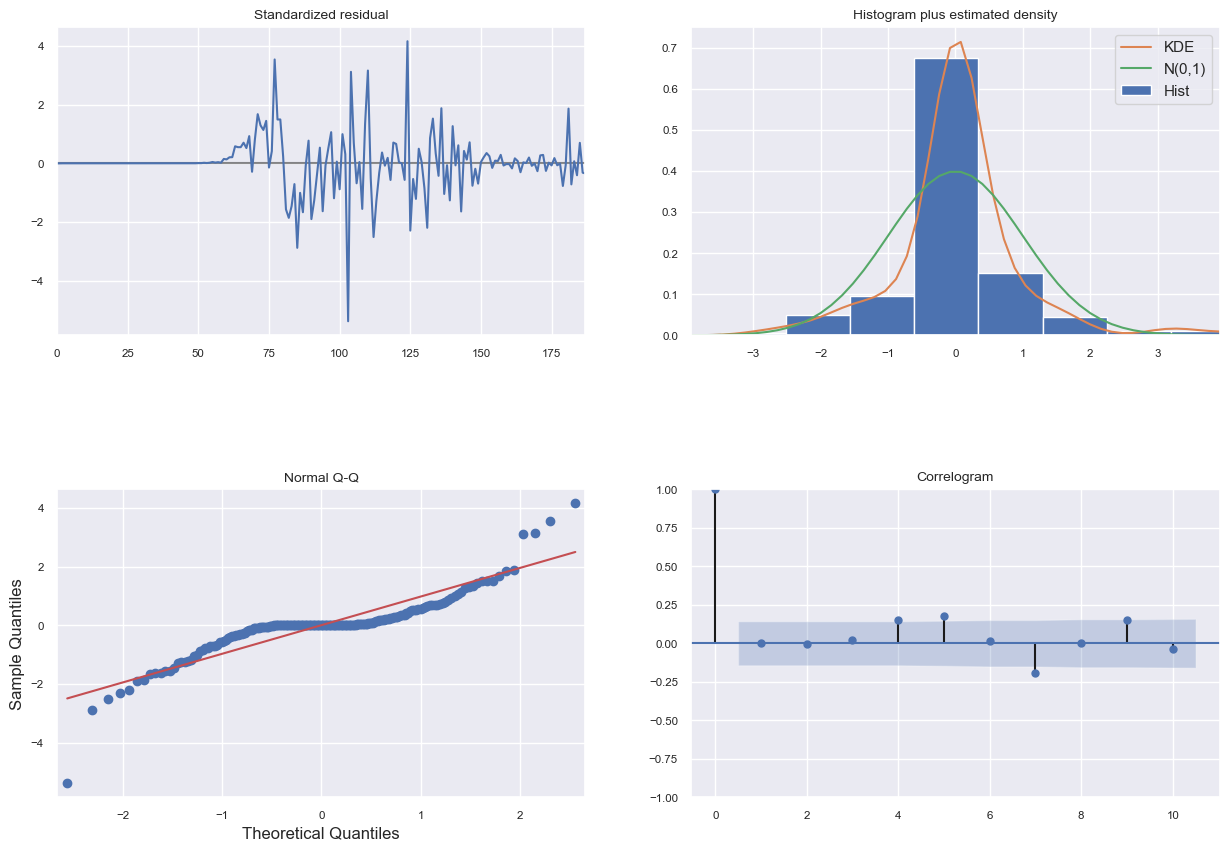

In [78]:
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()

In [13]:
modelauto = pm.auto_arima(covid_esp_newcases, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                    #  seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelauto.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3090.927, BIC=3103.999, Time=0.048 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=3103.476, BIC=3110.011, Time=0.008 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=3092.490, BIC=3102.294, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=3089.671, BIC=3099.474, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=3101.478, BIC=3104.746, Time=0.008 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=3091.034, BIC=3104.106, Time=0.032 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=3093.014, BIC=3109.353, Time=0.077 seconds
Total fit time: 0.228 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1541.835
Date:                Fri, 31 Jul 2020   AIC  

In [79]:
modelauto7 = pm.auto_arima(covid_esp_smooth7.dropna(), start_p=1, start_q=1,
                      test='kpss',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                    # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(modelauto7.summary())

Fit ARIMA(0,1,0)x(0,0,0,1) [intercept=True]; AIC=2493.809, BIC=2500.282, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,1) [intercept=True]; AIC=2405.359, BIC=2415.068, Time=0.064 seconds
Fit ARIMA(0,1,2)x(0,0,0,1) [intercept=True]; AIC=2378.364, BIC=2391.310, Time=0.088 seconds
Fit ARIMA(0,1,3)x(0,0,0,1) [intercept=True]; AIC=2353.236, BIC=2369.418, Time=0.120 seconds
Fit ARIMA(0,1,4)x(0,0,0,1) [intercept=True]; AIC=2339.616, BIC=2359.035, Time=0.148 seconds
Fit ARIMA(0,1,5)x(0,0,0,1) [intercept=True]; AIC=2328.236, BIC=2350.891, Time=0.339 seconds
Fit ARIMA(1,1,0)x(0,0,0,1) [intercept=True]; AIC=2325.113, BIC=2334.822, Time=0.036 seconds
Fit ARIMA(1,1,1)x(0,0,0,1) [intercept=True]; AIC=2304.454, BIC=2317.400, Time=0.080 seconds
Fit ARIMA(1,1,2)x(0,0,0,1) [intercept=True]; AIC=2305.805, BIC=2321.987, Time=0.128 seconds
Fit ARIMA(1,1,3)x(0,0,0,1) [intercept=True]; AIC=2299.182, BIC=2318.601, Time=0.104 seconds
Fit ARIMA(1,1,4)x(0,0,0,1) [intercept=True]; AIC=2298.473, BIC=2321.128, Time=0.

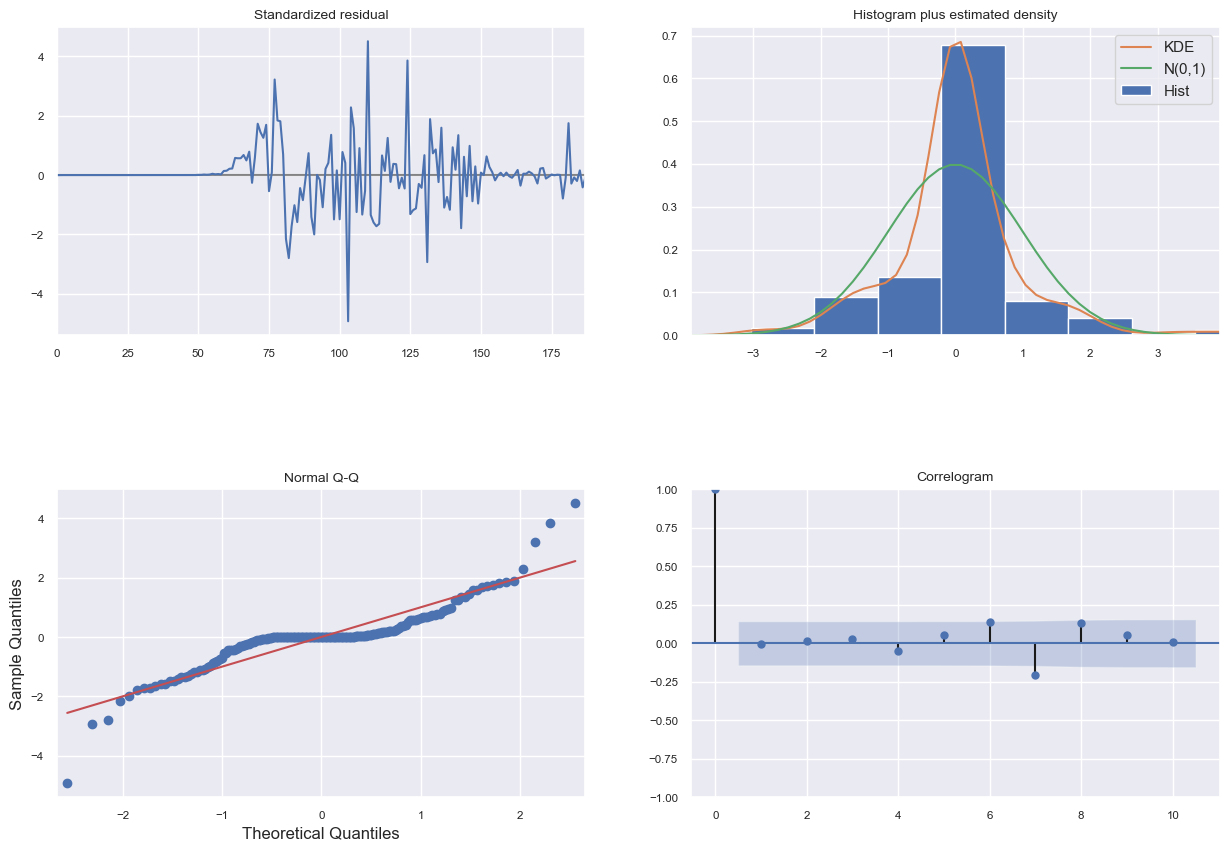

In [80]:
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()

In [20]:
modelauto7

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 4), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [51]:
mpis = modelauto7.predict_in_sample()

In [52]:
mpis.shape

(189,)

In [53]:
csm7_index = covid_esp_smooth7.index

In [54]:
csm7_index[8:]

DatetimeIndex(['2020-01-08', '2020-01-09', '2020-01-10', '2020-01-11',
               '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-15',
               '2020-01-16', '2020-01-17',
               ...
               '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06',
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10',
               '2020-07-11', '2020-07-12'],
              dtype='datetime64[ns]', name='date', length=187, freq='D')

In [55]:
mpiss = pd.Series(mpis)
mpiss.index = csm7_index[6:]
mpiss

date
2020-01-06      0.005446
2020-01-07      0.008164
2020-01-08      0.005553
2020-01-09      0.007422
2020-01-10      0.009509
                 ...    
2020-07-08    407.539783
2020-07-09    462.910777
2020-07-10    454.124829
2020-07-11    519.228944
2020-07-12    496.160839
Freq: D, Length: 189, dtype: float64

In [56]:
covid_esp_smooth7.shape

(195,)

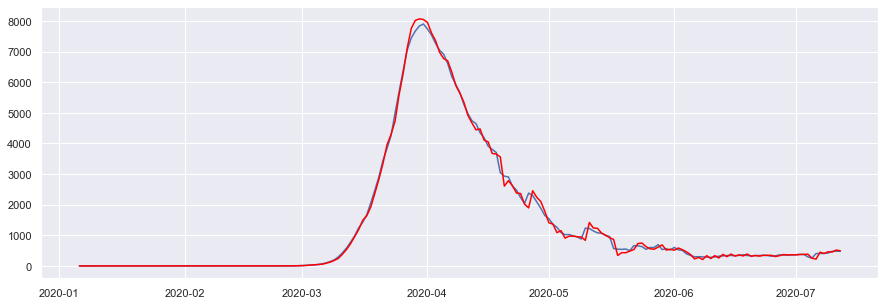

In [57]:
plt.plot(covid_esp_smooth7)
plt.plot(mpiss, color='red')
plt.show()

In [86]:
# We are going to use series covid_esp_smooth7 = covid_esp_newcases.rolling(7).mean() as our series to forecast. 
# Doing the rolling mean with 7 days makes sense to avoid daily changes in the original data, that maybe more related to how each 
# country reports the cases, rather than daily changes in the number of coronavirus cases.

# Doing a full grid search (auto_arima with step_wise algorithm set to False) gives us an arima (1, 2, 4) model with AIC 2289.501.

# Now we are going to look at best (p,d,q) splitting data in train - test:

In [21]:
# Split it into separate pieces
train, test = model_selection.train_test_split(covid_esp_smooth7, train_size=156)

# Fit a simple auto_arima model
mod1 = pm.auto_arima(train.dropna(), start_p=1, start_q=1, test='adf', max_p=10, max_q=10, m=1, d=None, seasonal=False, 
                      trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)

# Create predictions for the future, evaluate on test
preds, conf_int = mod1.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1876.964, BIC=1882.958, Time=0.008 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1849.065, BIC=1858.057, Time=0.048 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1850.729, BIC=1862.717, Time=0.072 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1847.217, BIC=1862.203, Time=0.072 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=1848.674, BIC=1866.657, Time=0.127 seconds
Fit ARIMA(0,2,5)x(0,0,0,0) [intercept=True]; AIC=1850.619, BIC=1871.599, Time=0.141 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1856.186, BIC=1865.178, Time=0.032 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1850.878, BIC=1862.867, Time=0.064 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1852.959, BIC=1867.945, Time=0.130 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=1848.787, BIC=1866.770, Time=0.162 seconds
Fit ARIMA(1,2,4)x(0,0,0,0) [intercept=True]; AIC=1841.967, BIC=1862.947, Time=0.

In [22]:
mod1

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 4), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [60]:
preds

array([  437.04709036,   461.96529016,   369.12149302,   377.55976312,
         285.47245544,   292.46253183,   201.10762816,   206.67333315,
         116.02727142,   120.19190969,    30.23163983,    33.01800963,
         -56.27901756,   -54.84861338,  -143.50445709,  -143.40820032,
        -231.4444404 ,  -232.66098695,  -320.09873432,  -322.6072039 ,
        -409.46711074,  -413.24707678,  -499.5493465 ,  -504.58082632,
        -590.3452233 ,  -596.60866842,  -681.85452758,  -689.33081433,
        -774.07705042,  -782.74747067,  -867.01258744,  -876.8588396 ,
        -960.66093869,  -971.66511886, -1055.02190859, -1067.16650192,
       -1150.09530579, -1163.36317803, -1245.88094311])

Text(0.5, 0, 'Year')

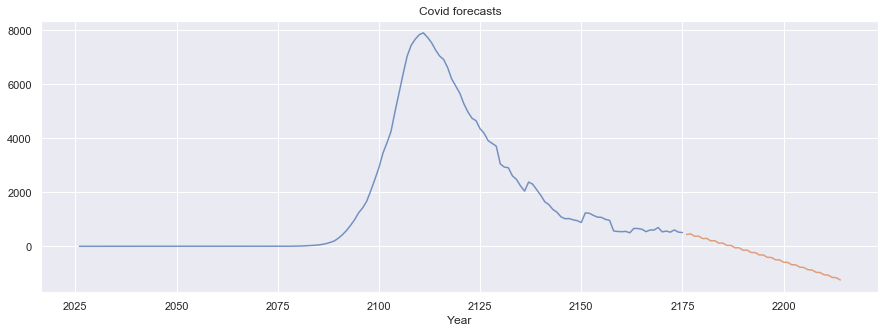

In [86]:
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 2020  # Year starts at 2020

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
#plt.scatter(x_years[x_axis[train.shape[0]:]], test,
#            alpha=0.4, marker='x')  # Test data
#plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
#                 conf_int[:, 0], conf_int[:, 1],
#                 alpha=0.1, color='b')
plt.title("Covid forecasts")
plt.xlabel("Year")

In [80]:
date_str = '20200101' # The date - 1 Jan 2020
format_str = '%Y%m%d' # The format
datetime_obj = datetime.datetime.strptime(date_str, format_str)
print(datetime_obj.date())

2020-01-01


In [83]:
x_axis

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [48]:
modelauto7 = pm.auto_arima(covid_esp_smooth7.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                     # m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                     # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(modelauto7.summary())

Fit ARIMA(0,2,0)x(0,0,0,1) [intercept=True]; AIC=2333.352, BIC=2339.814, Time=0.016 seconds
Fit ARIMA(0,2,1)x(0,0,0,1) [intercept=True]; AIC=2296.882, BIC=2306.575, Time=0.064 seconds
Fit ARIMA(0,2,2)x(0,0,0,1) [intercept=True]; AIC=2298.531, BIC=2311.456, Time=0.096 seconds
Fit ARIMA(0,2,3)x(0,0,0,1) [intercept=True]; AIC=2294.086, BIC=2310.242, Time=0.100 seconds
Fit ARIMA(0,2,4)x(0,0,0,1) [intercept=True]; AIC=2295.235, BIC=2314.622, Time=0.151 seconds
Fit ARIMA(0,2,5)x(0,0,0,1) [intercept=True]; AIC=2297.074, BIC=2319.692, Time=0.207 seconds
Fit ARIMA(1,2,0)x(0,0,0,1) [intercept=True]; AIC=2306.388, BIC=2316.081, Time=0.052 seconds
Fit ARIMA(1,2,1)x(0,0,0,1) [intercept=True]; AIC=2298.684, BIC=2311.608, Time=0.098 seconds
Fit ARIMA(1,2,2)x(0,0,0,1) [intercept=True]; AIC=2300.780, BIC=2316.936, Time=0.164 seconds
Fit ARIMA(1,2,3)x(0,0,0,1) [intercept=True]; AIC=2295.451, BIC=2314.837, Time=0.216 seconds
Fit ARIMA(1,2,4)x(0,0,0,1) [intercept=True]; AIC=2289.501, BIC=2312.118, Time=0.

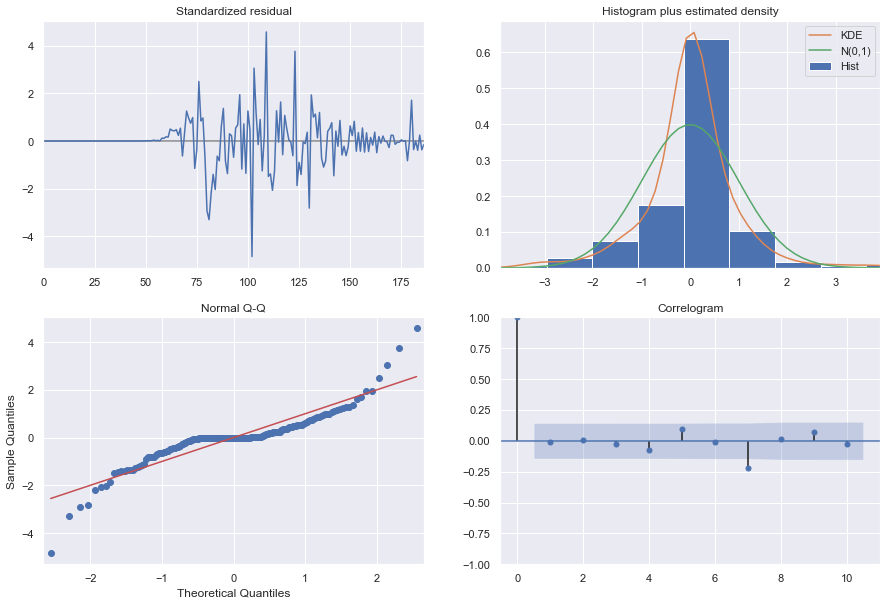

In [47]:
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()

In [64]:
modelauto7 = pm.auto_arima(np.sqrt(covid_esp_smooth7.diff()).dropna(), start_p=1, start_q=1,
                     # test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                     # m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                     # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(modelauto7.summary())

Fit ARIMA(0,0,0)x(0,0,0,1) [intercept=True]; AIC=790.495, BIC=795.985, Time=0.006 seconds
Fit ARIMA(0,0,1)x(0,0,0,1) [intercept=True]; AIC=733.842, BIC=742.077, Time=0.030 seconds
Fit ARIMA(0,0,2)x(0,0,0,1) [intercept=True]; AIC=665.556, BIC=676.536, Time=0.063 seconds
Fit ARIMA(0,0,3)x(0,0,0,1) [intercept=True]; AIC=630.882, BIC=644.607, Time=0.167 seconds
Fit ARIMA(0,0,4)x(0,0,0,1) [intercept=True]; AIC=617.660, BIC=634.130, Time=0.100 seconds
Fit ARIMA(0,0,5)x(0,0,0,1) [intercept=True]; AIC=605.731, BIC=624.945, Time=0.096 seconds
Fit ARIMA(1,0,0)x(0,0,0,1) [intercept=True]; AIC=629.945, BIC=638.179, Time=0.015 seconds
Fit ARIMA(1,0,1)x(0,0,0,1) [intercept=True]; AIC=592.626, BIC=603.606, Time=0.033 seconds
Fit ARIMA(1,0,2)x(0,0,0,1) [intercept=True]; AIC=566.608, BIC=580.332, Time=0.061 seconds
Fit ARIMA(1,0,3)x(0,0,0,1) [intercept=True]; AIC=561.896, BIC=578.365, Time=0.061 seconds
Fit ARIMA(1,0,4)x(0,0,0,1) [intercept=True]; AIC=562.977, BIC=582.191, Time=0.076 seconds
Fit ARIMA(

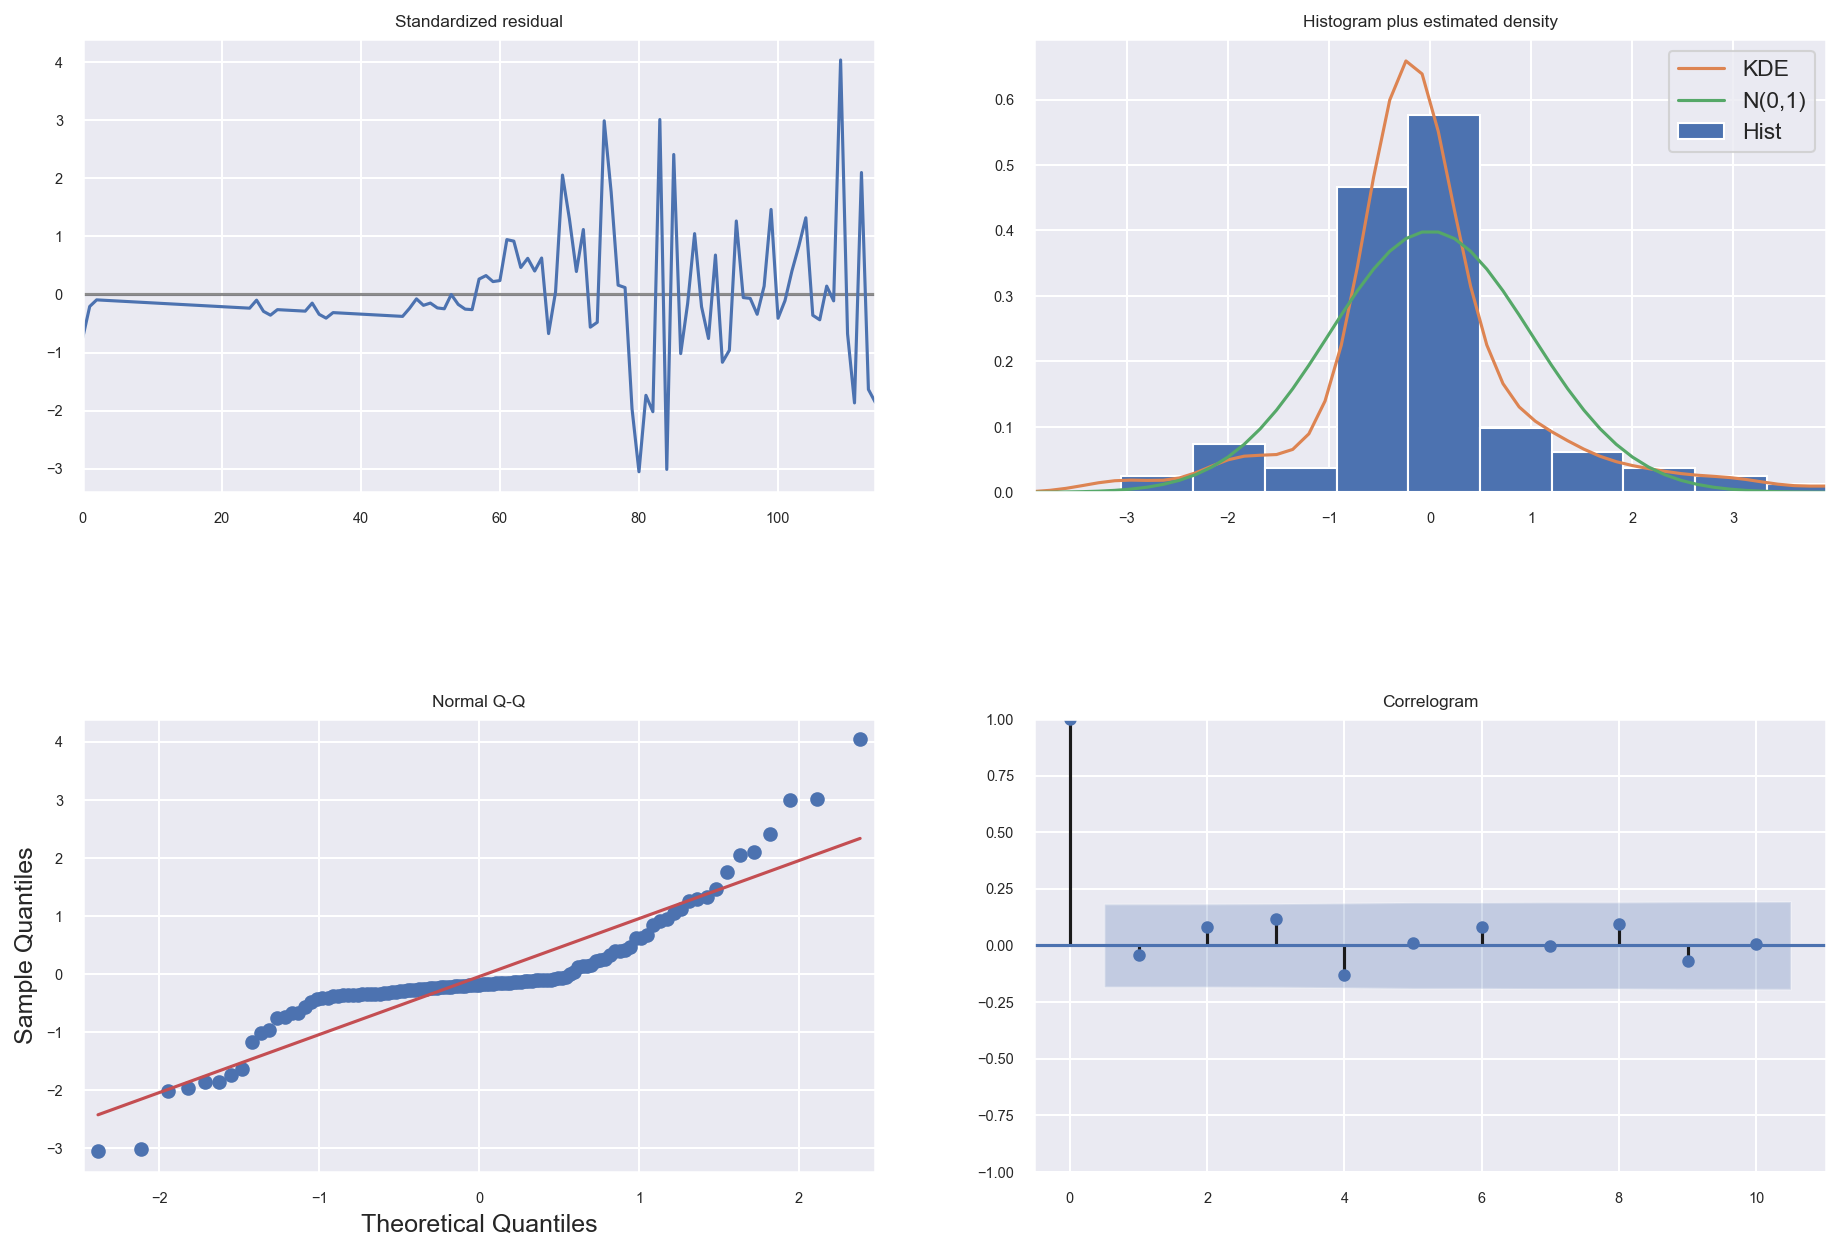

In [65]:
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()

In [90]:
covid_esp_smooth7.loc[(covid_esp_smooth7!=0).any()]

TypeError: Cannot convert input [True] of type <class 'numpy.bool_'> to Timestamp

In [86]:
from pmdarima import preprocessing

cov_prep = preprocessing.LogEndogTransformer(covid_esp_smooth7.loc[~(covid_esp_smooth7==0).all()])
cov_prep.get_params()
#cov_prep.fit_transform(covid_esp_smooth7)

#modelauto7 = pm.auto_arima(np.sqrt(covid_esp_smooth7.diff()).dropna(), start_p=1, start_q=1,
                     # test='adf',       # use adftest to find optimal 'd'
#                      max_p=10, max_q=10, # maximum p and q
                     # m=1,              # frequency of series
#                      d=0,           # let model determine 'd'
                     # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
#                      trace=True,
#                      error_action='ignore',  
#                      suppress_warnings=True, 
#                      stepwise=False)

#print(modelauto7.summary())

TypeError: Cannot convert input [True] of type <class 'numpy.bool_'> to Timestamp

In [66]:
modelauto7x = pm.auto_arima(covid_esp_smooth7[7:-12], exogenous=flights_esp_arr_smooth7.dropna().to_numpy().reshape(-1,1), 
                            start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                     # m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                    #  seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(modelauto7x.summary())

Fit ARIMA(0,2,0)x(0,0,0,1) [intercept=True]; AIC=2180.575, BIC=2190.052, Time=0.016 seconds
Fit ARIMA(0,2,1)x(0,0,0,1) [intercept=True]; AIC=2147.983, BIC=2160.619, Time=0.072 seconds
Fit ARIMA(0,2,2)x(0,0,0,1) [intercept=True]; AIC=2149.697, BIC=2165.492, Time=0.201 seconds
Fit ARIMA(0,2,3)x(0,0,0,1) [intercept=True]; AIC=2145.720, BIC=2164.675, Time=0.150 seconds
Fit ARIMA(0,2,4)x(0,0,0,1) [intercept=True]; AIC=2146.531, BIC=2168.644, Time=0.219 seconds
Fit ARIMA(0,2,5)x(0,0,0,1) [intercept=True]; AIC=2148.529, BIC=2173.802, Time=0.248 seconds
Fit ARIMA(1,2,0)x(0,0,0,1) [intercept=True]; AIC=2156.126, BIC=2168.762, Time=0.072 seconds
Fit ARIMA(1,2,1)x(0,0,0,1) [intercept=True]; AIC=2149.820, BIC=2165.615, Time=0.160 seconds
Fit ARIMA(1,2,2)x(0,0,0,1) [intercept=True]; AIC=2151.887, BIC=2170.842, Time=0.274 seconds
Fit ARIMA(1,2,3)x(0,0,0,1) [intercept=True]; AIC=2146.725, BIC=2168.838, Time=0.236 seconds
Fit ARIMA(1,2,4)x(0,0,0,1) [intercept=True]; AIC=2141.565, BIC=2166.838, Time=0.

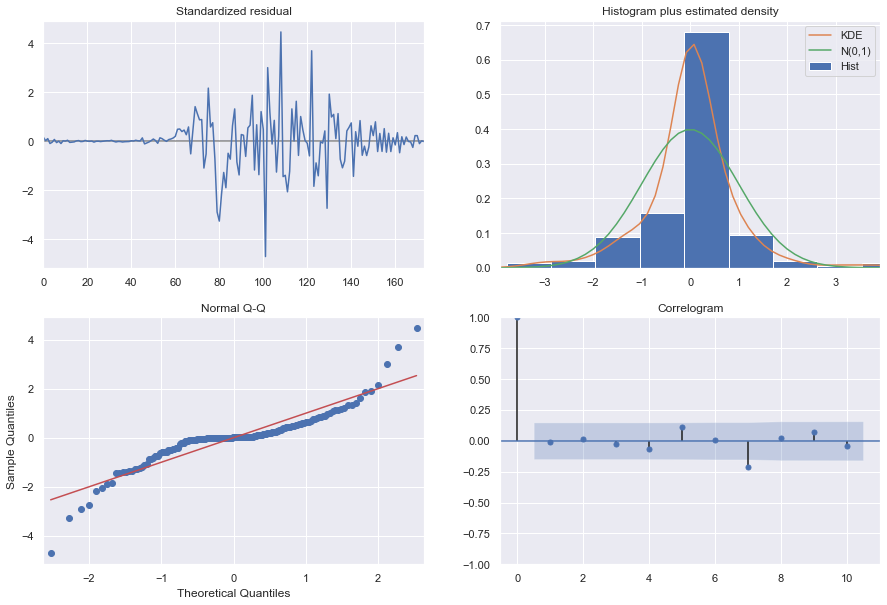

In [67]:
modelauto7x.plot_diagnostics(figsize=(15,10))
plt.show()

In [122]:
y[7:-12].head(10)

,0
date,
2020-01-07,0.0
2020-01-08,0.0
2020-01-09,0.0
2020-01-10,0.0
2020-01-11,0.0
2020-01-12,0.0
2020-01-13,0.0
2020-01-14,0.0
2020-01-15,0.0


In [121]:
X.dropna().head()

,0,1,2,3,4,5,6,7,8
2020-01-07,0.959820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.964873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-09,0.949592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-10,0.941800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-11,0.921344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
modelauto7x = pm.auto_arima(y[7:-12], exogenous=X.dropna(), 
                            start_p=1, start_q=1,
                      test='pp',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                     # m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                    #  seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelauto7x.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-974.331, BIC=-933.188, Time=0.558 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-895.478, BIC=-860.665, Time=0.421 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-958.234, BIC=-920.257, Time=0.475 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-934.102, BIC=-896.124, Time=0.480 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-885.838, BIC=-854.190, Time=0.442 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-958.767, BIC=-914.460, Time=0.555 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-975.246, BIC=-930.939, Time=0.554 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-940.212, BIC=-899.070, Time=0.608 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-973.742, BIC=-926.270, Time=0.692 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=-980.183, BIC=-932.711, Time=0.669 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercep

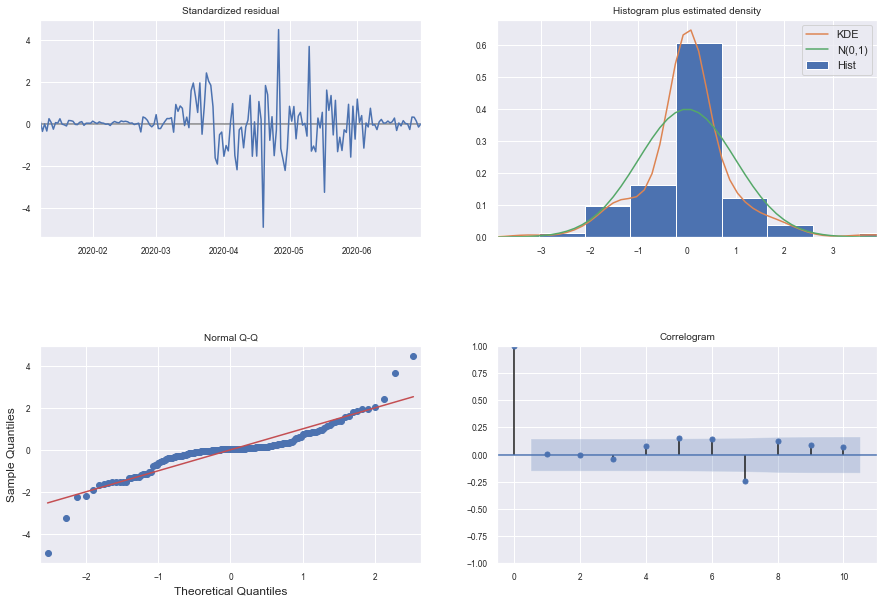

In [129]:
modelauto7x.plot_diagnostics(figsize=(15,10))
plt.show()

In [97]:
# Split it into separate pieces
train, test = model_selection.train_test_split(covid_esp_smooth7.diff().diff(), train_size=156)

# Fit a simple auto_arima model
mod1 = pm.auto_arima(train.dropna(), start_p=1, start_q=1, test='adf', max_p=10, max_q=10, m=1, seasonal=False, 
                      trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)

# Create predictions for the future, evaluate on test
preds, conf_int = mod1.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1876.964, BIC=1882.958, Time=0.008 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=1849.071, BIC=1858.063, Time=0.056 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=1850.735, BIC=1862.724, Time=0.074 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=1847.226, BIC=1862.212, Time=0.080 seconds
Fit ARIMA(0,0,4)x(0,0,0,0) [intercept=True]; AIC=1848.683, BIC=1866.666, Time=0.110 seconds
Fit ARIMA(0,0,5)x(0,0,0,0) [intercept=True]; AIC=1850.628, BIC=1871.609, Time=0.159 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=1856.189, BIC=1865.181, Time=0.025 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=1850.884, BIC=1862.873, Time=0.073 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=1852.965, BIC=1867.951, Time=0.106 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=1848.796, BIC=1866.779, Time=0.160 seconds
Fit ARIMA(1,0,4)x(0,0,0,0) [intercept=True]; AIC=1841.980, BIC=1862.960, Time=0.

Text(0.5, 1.0, 'Covid forecasts')

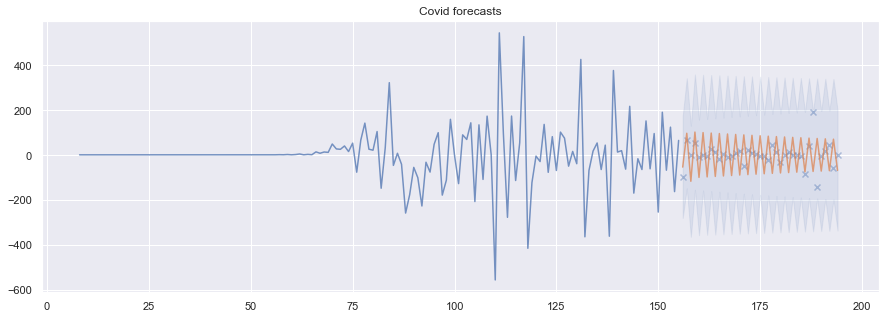

In [102]:
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis  # Year starts at 2020

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
plt.scatter(x_years[x_axis[train.shape[0]:]], test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Covid forecasts")

In [104]:
modelf = sm.tsa.statespace.SARIMAX(covid_esp_smooth7.diff().diff(), order=(1,0,4))
results = modelf.fit()

In [113]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  195
Model:               SARIMAX(1, 0, 4)   Log Likelihood               -1137.755
Date:                Thu, 30 Jul 2020   AIC                           2287.509
Time:                        19:39:17   BIC                           2307.147
Sample:                    12-31-2019   HQIC                          2295.460
                         - 07-12-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9526      0.066    -14.456      0.000      -1.082      -0.823
ma.L1          0.5065      0.082      6.143      0.000       0.345       0.668
ma.L2         -0.5271      0.062     -8.497      0.000      -0.649      -0.406
ma.L3          0.1611      0.057      2.846      0.004       0.050       0.272
ma.L4          0.3269      0.051      6.381      0.000       0.226       0.427
sigma2      1.123e+04    633.282     17.732      0.000    9987.835    1.25e+04
===================================================================================
Ljung-Box (Q):                       50.04   Jarque-Bera (JB):               371.22
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):           16269.89   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[  32.09068796  -34.06984232   36.58899258  -22.48648978   28.50791314
  -22.96089166    1.28056353    3.27338068   15.66182673  -16.57059149
   -2.91595239   -3.88350646    5.79791675   16.48157704  -12.46965519
  -18.80700874    5.79018965   17.24851592   -5.29977361   -0.3771291
   -4.70883967    3.48531485   36.35572665   10.79665564 -105.34129144
   -6.60368878   55.89597832   18.11033617  -19.78218846   15.72423163]


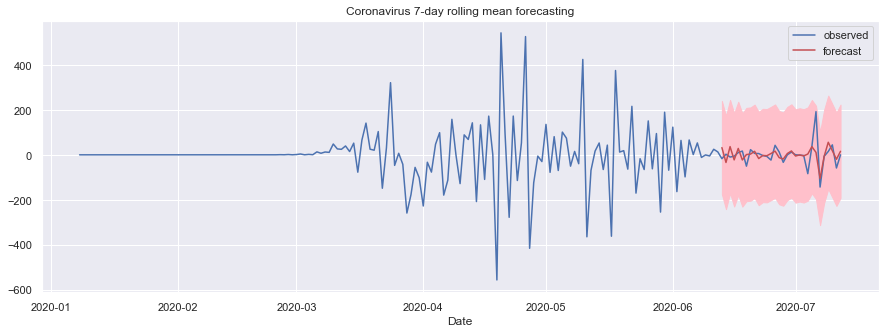

In [129]:
# Generate in sample predictions
one_step_forecast = results.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(covid_esp_smooth7.diff().diff().index, covid_esp_smooth7.diff().diff(), label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecasting')
plt.legend()
plt.show()

In [111]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(covid_esp_smooth7.diff().diff()[-30:], (mean_forecast.values))))

Test RMSE: 44.846


[  3.30797604   7.49199654 -22.34828258  16.14940498 -15.38397067
  14.65481569 -13.96022051  13.29854711 -12.66823507  12.06779798
 -11.49581984  10.95095177 -10.43190886   9.93746705]


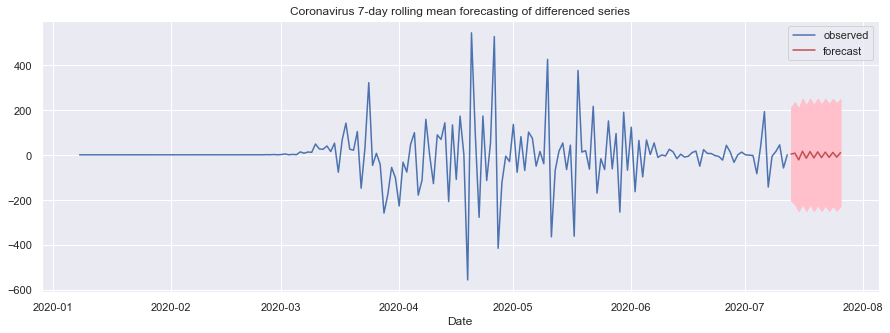

In [130]:
# Generate out of sample predictions
forecast = results.get_forecast(steps=14)

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(covid_esp_smooth7.diff().diff().index, covid_esp_smooth7.diff().diff(), label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecasting of differenced series')
plt.legend()
plt.show()

[483.73654747 491.22854401 468.88026143 485.02966641 469.64569574
 484.30051143 470.34029092 483.63883803 470.97060295 483.03840093
 471.5425811  482.49353287 472.06162401 481.99909106]


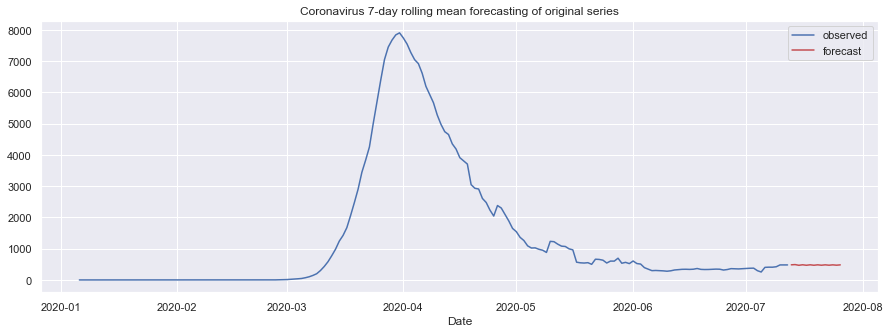

In [131]:
mean_forecast_orig = np.cumsum(mean_forecast) + covid_esp_smooth7[-1]

# Print best estimate  predictions
print(mean_forecast_orig.values)

# plot the data
plt.plot(covid_esp_smooth7.index, covid_esp_smooth7, label='observed')

# plot your mean predictions
plt.plot(mean_forecast_orig.index, mean_forecast_orig, color='r', label='forecast')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecasting of original series')
plt.legend()
plt.show()

In [133]:
covid_esp_smooth7.tail(10)

date
2020-07-03    377.142857
2020-07-04    296.571429
2020-07-05    253.571429
2020-07-06    402.714286
2020-07-07    408.428571
2020-07-08    407.714286
2020-07-09    421.857143
2020-07-10    480.428571
2020-07-11    480.428571
2020-07-12    480.428571
Freq: D, Name: new_cases, dtype: float64

In [137]:
covid_esp_smooth7.diff().tail(10)

date
2020-07-03      3.285714
2020-07-04    -80.571429
2020-07-05    -43.000000
2020-07-06    149.142857
2020-07-07      5.714286
2020-07-08     -0.714286
2020-07-09     14.142857
2020-07-10     58.571429
2020-07-11      0.000000
2020-07-12      0.000000
Freq: D, Name: new_cases, dtype: float64

In [135]:
covid_esp_smooth7.diff().diff().tail(10)

date
2020-07-03     -3.000000
2020-07-04    -83.857143
2020-07-05     37.571429
2020-07-06    192.142857
2020-07-07   -143.428571
2020-07-08     -6.428571
2020-07-09     14.857143
2020-07-10     44.428571
2020-07-11    -58.571429
2020-07-12      0.000000
Freq: D, Name: new_cases, dtype: float64

In [136]:
covid_esp_smooth7.diff(2).tail(10)

date
2020-07-03      9.571429
2020-07-04    -77.285714
2020-07-05   -123.571429
2020-07-06    106.142857
2020-07-07    154.857143
2020-07-08      5.000000
2020-07-09     13.428571
2020-07-10     72.714286
2020-07-11     58.571429
2020-07-12      0.000000
Freq: D, Name: new_cases, dtype: float64

In [147]:
np.cumsum(covid_esp_smooth7.diff().diff()).tail(10)

date
2020-07-03      3.285714
2020-07-04    -80.571429
2020-07-05    -43.000000
2020-07-06    149.142857
2020-07-07      5.714286
2020-07-08     -0.714286
2020-07-09     14.142857
2020-07-10     58.571429
2020-07-11      0.000000
2020-07-12      0.000000
Freq: D, Name: new_cases, dtype: float64

In [21]:
modelf = sm.tsa.statespace.SARIMAX(covid_esp_smooth7, order=(0,2,1))
results = modelf.fit()

In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  195
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1161.372
Date:                Fri, 31 Jul 2020   AIC                           2326.744
Time:                        23:32:25   BIC                           2333.270
Sample:                    12-31-2019   HQIC                          2329.387
                         - 07-12-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4612      0.040    -11.665      0.000      -0.539      -0.384
sigma2       1.22e+04    606.471     20.118      0.000     1.1e+04    1.34e+04
===================================================================================
Ljung-Box (Q):                       71.80   Jarque-Bera (JB):               391.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           13939.64   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Finally, we can conclude that our data (covid_esp_smooth7) gives good results with ARIMA model
# when 2 is the order differencing (auto_arima always returns 2) so d=2. So when looking at results all together, the best 
# order options are (1, 2, 4). We are going to train an arima model with (1, 2, 4)

In [23]:
modelf = sm.tsa.statespace.SARIMAX(covid_esp_smooth7, order=(1,2,4))
results = modelf.fit()

In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  195
Model:               SARIMAX(1, 2, 4)   Log Likelihood               -1153.714
Date:                Fri, 31 Jul 2020   AIC                           2319.427
Time:                        12:25:51   BIC                           2339.003
Sample:                    12-31-2019   HQIC                          2327.355
                         - 07-12-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9526      0.066    -14.440      0.000      -1.082      -0.823
ma.L1          0.5049      0.082      6.122      0.000       0.343       0.667
ma.L2         -0.5292      0.062     -8.551      0.000      -0.650      -0.408
ma.L3          0.1596      0.056      2.835      0.005       0.049       0.270
ma.L4          0.3259      0.051      6.376      0.000       0.226       0.426
sigma2       1.12e+04    630.108     17.777      0.000    9966.214    1.24e+04
===================================================================================
Ljung-Box (Q):                       49.50   Jarque-Bera (JB):               356.70
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):           15761.86   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

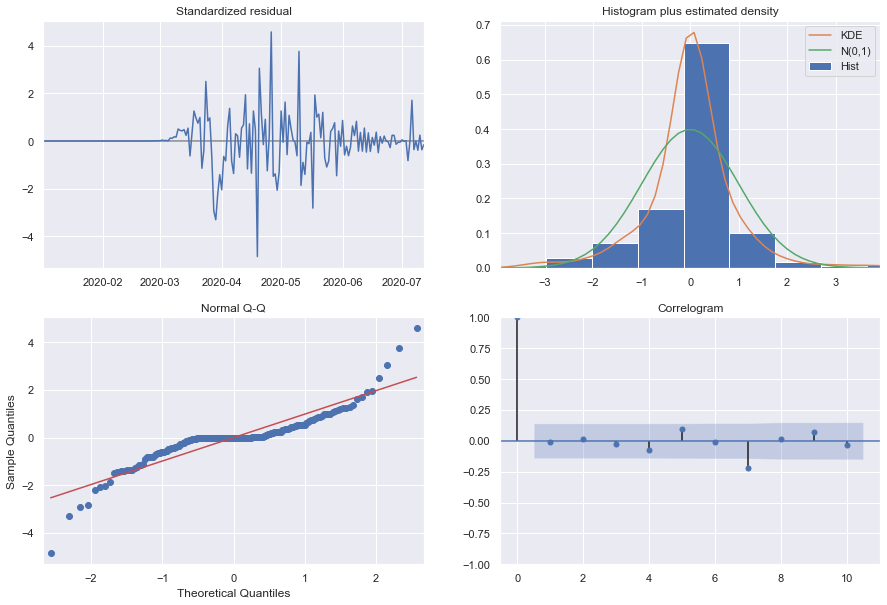

In [25]:
results.plot_diagnostics(figsize=(15,10))
plt.show()

[377.03671631 303.06710902 388.12954325 321.31037841 361.652091
 326.21325651 389.68812356 313.4285589  344.24324337 319.86443471
 346.52532224 346.48591339 346.09765228 306.89868593 336.42897686
 371.42334381 357.9427535  364.90107983 362.17633548 374.89328024
 375.47734528 383.89297577 252.5069269  221.45200315 446.38167181
 407.41283371 462.63167811 454.11159138 519.21977092 496.30547788]


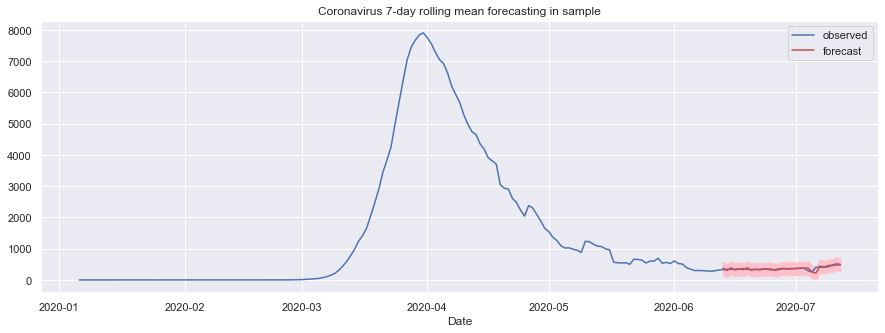

In [26]:
# Generate in sample predictions
one_step_forecast = results.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(covid_esp_smooth7.index, covid_esp_smooth7, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecasting in sample')
plt.legend()
plt.show()

In [27]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(covid_esp_smooth7[-30:], (mean_forecast.values))))

Test RMSE: 44.812


In [50]:
print("Test MAE: %.3f" % np.mean(abs(results.resid)))

Test MAE: 59.983


[483.85085886 494.80031829 483.40433379 488.12173469 477.48878397
 481.47928382 471.53881245 474.86962464 465.55760205 468.28972504
 459.54804131 461.73683329 453.51275166 455.20845208]


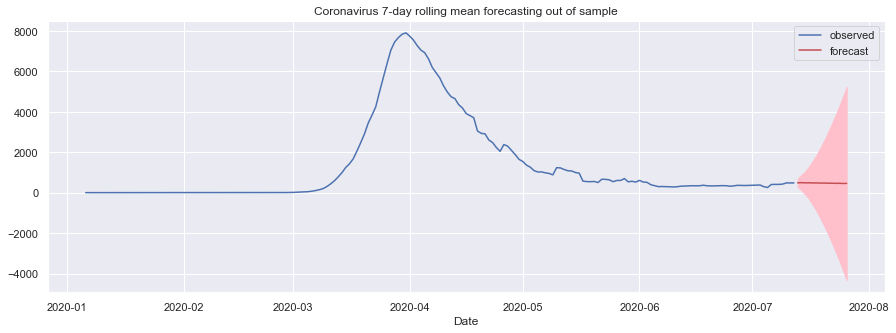

In [28]:
# Generate out of sample predictions
forecast = results.get_forecast(steps=14)

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(covid_esp_smooth7.index, covid_esp_smooth7, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecasting out of sample')
plt.legend()
plt.show()

In [45]:
# Now we are going to add the first exogenous variable: daily number of arrival flights.
# This data for Spain is stored in 'vuelos_esp.csv'

In [15]:
flights_esp = pd.read_csv('./data/vuelos_esp.csv',parse_dates=["FLT_DATE"],index_col="FLT_DATE")
flights_esp_arr = flights_esp["FLT_ARR_1"]
flights_esp_arr = flights_esp_arr.resample("1D").sum()

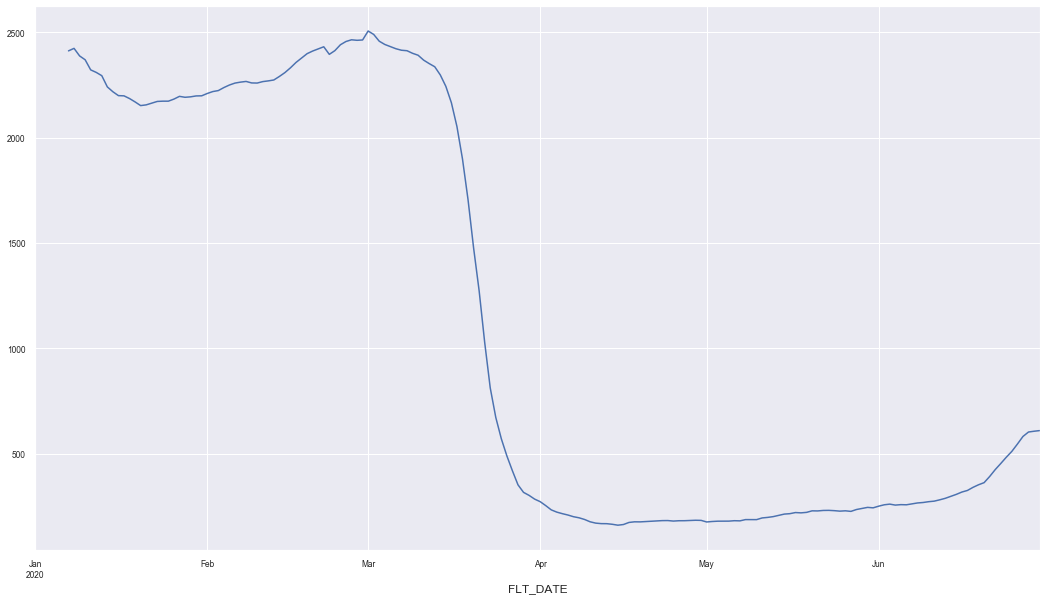

In [16]:
flights_esp_arr_smooth7 = flights_esp_arr.rolling(7).mean()
flights_esp_arr_smooth7.plot()
plt.show()

In [18]:
covid_esp_smooth7[7:-12].head(10)

date
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
Freq: D, Name: new_cases, dtype: float64

In [48]:
flights_esp_arr_smooth7.head(10)

FLT_DATE
2020-01-01            NaN
2020-01-02            NaN
2020-01-03            NaN
2020-01-04            NaN
2020-01-05            NaN
2020-01-06            NaN
2020-01-07    2412.571429
2020-01-08    2424.428571
2020-01-09    2388.571429
2020-01-10    2370.285714
Freq: D, Name: FLT_ARR_1, dtype: float64

In [49]:
covid_esp_smooth7[7:-12].shape

(176,)

In [21]:
modelfx = sm.tsa.statespace.SARIMAX(covid_esp_smooth7[7:-12], order=(1,2,4), exog=flights_esp_arr_smooth7.dropna())
resultsx = modelfx.fit()

In [22]:
resultsx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  176
Model:               SARIMAX(1, 2, 4)   Log Likelihood               -1062.783
Date:                Sun, 02 Aug 2020   AIC                           2139.565
Time:                        20:37:50   BIC                           2161.679
Sample:                    01-07-2020   HQIC                          2148.536
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FLT_ARR_1      0.3325      0.455      0.731      0.465      -0.559       1.224
ar.L1         -0.9515      0.070    -13.511      0.000      -1.089      -0.813
ma.L1          0.5082      0.088      5.791      0.000       0.336       0.680
ma.L2         -0.5128      0.067     -7.618      0.000      -0.645      -0.381
ma.L3          0.1834      0.062      2.968      0.003       0.062       0.305
ma.L4          0.3377      0.055      6.127      0.000       0.230       0.446
sigma2      1.177e+04    702.216     16.761      0.000    1.04e+04    1.31e+04
===================================================================================
Ljung-Box (Q):                       46.75   Jarque-Bera (JB):               261.46
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):             268.22   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

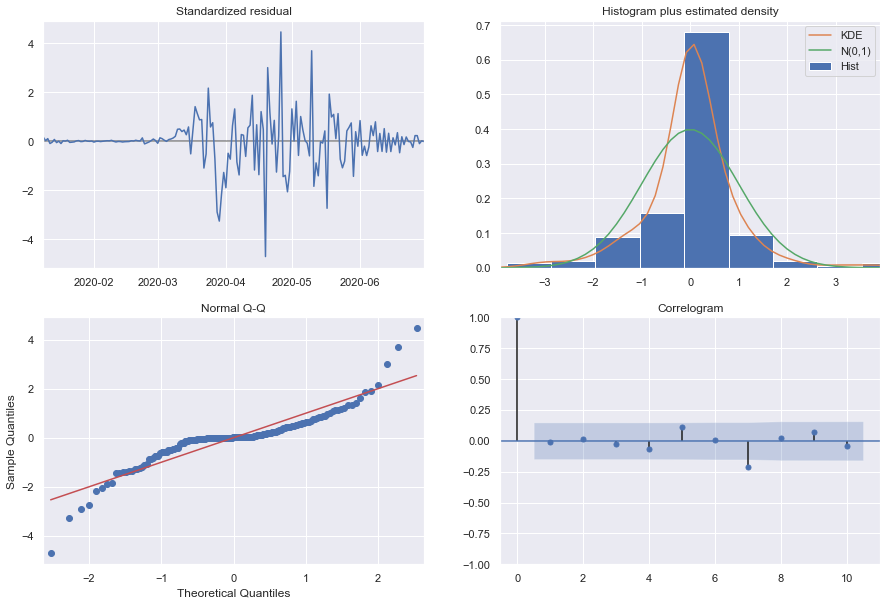

In [23]:
resultsx.plot_diagnostics(figsize=(15,10))
plt.show()

In [83]:
modelfx = sm.tsa.statespace.SARIMAX(covid_esp_smooth7[7:-12], order=(3,1,2), exog=flights_esp_arr_smooth7.dropna())
resultsx = modelfx.fit()
resultsx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  176
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1067.156
Date:                Sat, 08 Aug 2020   AIC                           2148.311
Time:                        00:06:50   BIC                           2170.465
Sample:                    01-07-2020   HQIC                          2157.297
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FLT_ARR_1     -0.0298      0.395     -0.076      0.940      -0.803       0.744
ar.L1          1.5643      0.139     11.279      0.000       1.292       1.836
ar.L2         -1.0120      0.146     -6.919      0.000      -1.299      -0.725
ar.L3          0.3581      0.090      3.979      0.000       0.182       0.534
ma.L1         -1.1216      0.135     -8.280      0.000      -1.387      -0.856
ma.L2          0.7187      0.076      9.474      0.000       0.570       0.867
sigma2      1.149e+04    681.239     16.869      0.000    1.02e+04    1.28e+04
===================================================================================
Ljung-Box (Q):                       50.11   Jarque-Bera (JB):               247.45
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):            9477.66   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

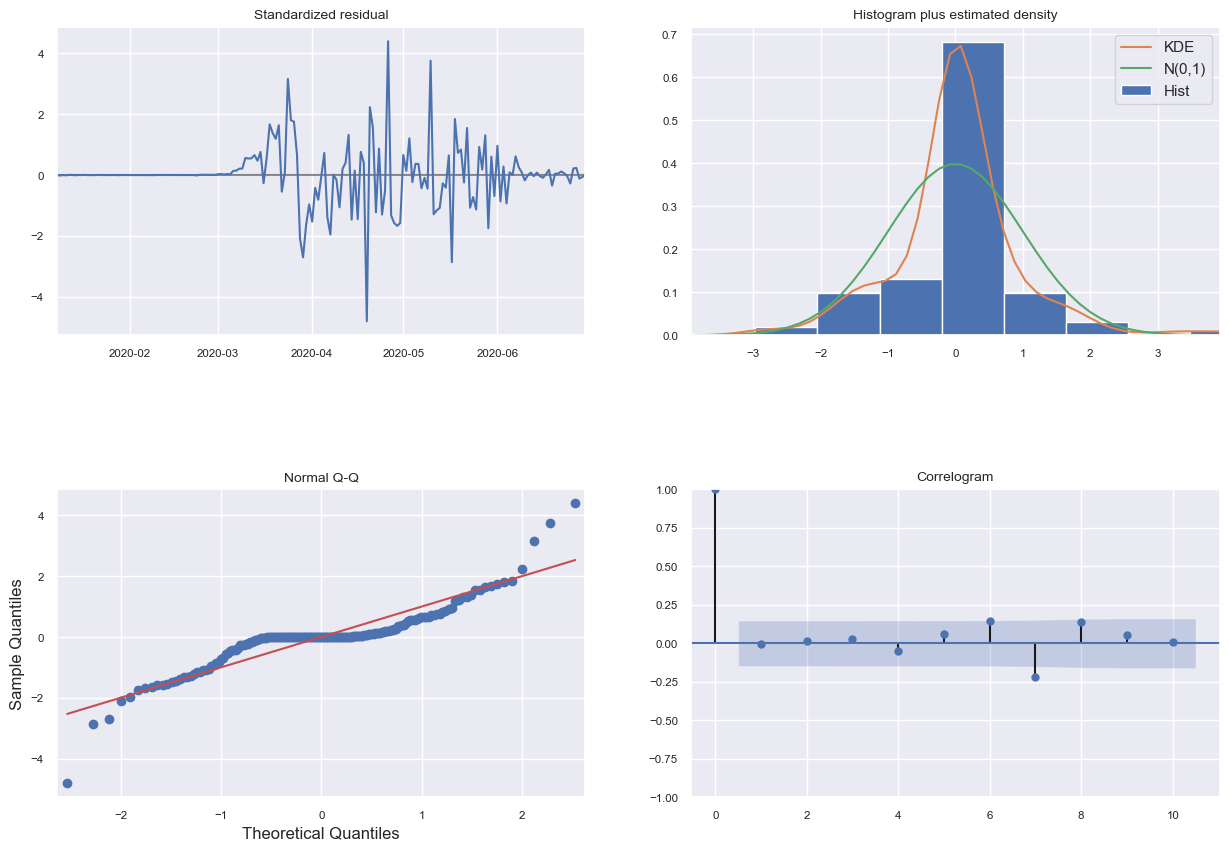

In [84]:
resultsx.plot_diagnostics(figsize=(15,10))
plt.show()

In [64]:
# Import joblib
#import joblib

# Set model name
#filename(and path) = ____.pkl

# Pickle it
#joblib.dump(__model__,__filename__)

# Load the model back in
#loaded_model = joblib.load(___filename____)

# Update the model
#loaded_model.update(__dfnew___)

In [60]:
covid_esp_smooth7[7:-12].shape

(176,)

In [17]:
varc1 = pd.read_csv('./data/variable_c1.csv', parse_dates=[0], index_col=[0])
varc1 = varc1['Spain']
varc1.rename('c1_schoolclosing', inplace=True)
varc1_smooth7 = varc1.rolling(7).mean()
varc1_smooth7.dropna().shape

(176,)

In [18]:
exogconcat = pd.concat([flights_esp_arr_smooth7, varc1_smooth7], axis=1)

In [19]:
varc2 = pd.read_csv('./data/variable_c2.csv', parse_dates=[0], index_col=[0])
varc2 = varc2['Spain']
varc2.rename('c2_workplaceclosing', inplace=True)
varc2_smooth7 = varc2.rolling(7).mean()
exogconcat = pd.concat([exogconcat, varc2_smooth7], axis=1)

In [20]:
varc3 = pd.read_csv('./data/variable_c3.csv', parse_dates=[0], index_col=[0])
varc3 = varc3['Spain']
varc3.rename('c3_cancelpublicevents', inplace=True)
varc3_smooth7 = varc3.rolling(7).mean()
exogconcat = pd.concat([exogconcat, varc3_smooth7], axis=1)

In [21]:
varc4 = pd.read_csv('./data/variable_c4.csv', parse_dates=[0], index_col=[0])
varc4 = varc4['Spain']
varc4.rename('c4_restrictionsongatherings', inplace=True)
varc4_smooth7 = varc4.rolling(7).mean()
exogconcat = pd.concat([exogconcat, varc4_smooth7], axis=1)

In [22]:
varc5 = pd.read_csv('./data/variable_c5.csv', parse_dates=[0], index_col=[0])
varc5 = varc5['Spain']
varc5.rename('c5_closepublictransport', inplace=True)
varc5_smooth7 = varc5.rolling(7).mean()
exogconcat = pd.concat([exogconcat, varc5_smooth7], axis=1)

In [23]:
varc6 = pd.read_csv('./data/variable_c6.csv', parse_dates=[0], index_col=[0])
varc6 = varc6['Spain']
varc6.rename('c6_stayathomerequirements', inplace=True)
varc6_smooth7 = varc6.rolling(7).mean()
exogconcat = pd.concat([exogconcat, varc6_smooth7], axis=1)

In [24]:
varc7 = pd.read_csv('./data/variable_c7.csv', parse_dates=[0], index_col=[0])
varc7 = varc7['Spain']
varc7.rename('c7_domestictravel', inplace=True)
varc7_smooth7 = varc7.rolling(7).mean()
exogconcat = pd.concat([exogconcat, varc7_smooth7], axis=1)

In [25]:
varc8 = pd.read_csv('./data/variable_c8.csv', parse_dates=[0], index_col=[0])
varc8 = varc8['Spain']
varc8.rename('c8_internationaltravel', inplace=True)
varc8_smooth7 = varc8.rolling(7).mean()
exogconcat = pd.concat([exogconcat, varc8_smooth7], axis=1)

In [26]:
exogconcat.sample(10)

,FLT_ARR_1,c1_schoolclosing,c2_workplaceclosing,c3_cancelpublicevents,c4_restrictionsongatherings,c5_closepublictransport,c6_stayathomerequirements,c7_domestictravel,c8_internationaltravel
2020-03-03,2458.428571,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2020-06-26,545.428571,2.000000,0.142857,2.0,2.142857,0.0,0.142857,0.142857,1.428571
2020-05-03,179.285714,3.000000,3.000000,2.0,4.000000,1.0,2.000000,1.000000,4.000000
2020-06-24,483.000000,2.000000,0.428571,2.0,2.428571,0.0,0.428571,0.428571,2.285714
2020-01-09,2388.571429,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2020-02-06,2259.571429,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2020-05-17,220.285714,3.000000,3.000000,2.0,4.000000,1.0,2.000000,1.000000,4.000000
2020-01-08,2424.428571,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2020-02-10,2259.714286,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2020-05-29,239.857143,2.428571,2.000000,2.0,4.000000,1.0,1.571429,1.000000,4.000000


In [116]:
from sklearn.preprocessing import MinMaxScaler

sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogconcat)
scaled_input =pd.DataFrame(scaled_input, index=exogconcat.index)
X = scaled_input

In [117]:
X.head(10)

,0,1,2,3,4,5,6,7,8
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,0.959820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.964873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-09,0.949592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-10,0.941800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
covid_esp_smooth7.shape

(195,)

In [56]:
covid_esp_smooth7.values.reshape(-1,1)

array([[           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.42857143e-01],
       [1.42857143e-01],
       [1.42857143e-01],
       [1.42857143e-01],
       [1.42857143e-01],
       [1.42857143e-01],
       [1.42857143e-01],
       [0.00000000e+00],


In [113]:
covid_esp_smooth7.index

DatetimeIndex(['2019-12-31', '2020-01-01', '2020-01-02', '2020-01-03',
               '2020-01-04', '2020-01-05', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09',
               ...
               '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06',
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10',
               '2020-07-11', '2020-07-12'],
              dtype='datetime64[ns]', name='date', length=195, freq='D')

In [115]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(covid_esp_smooth7.values.reshape(-1,1))
scaler_output =pd.DataFrame(scaler_output, index=covid_esp_smooth7.index)
y=scaler_output
y

,0
date,
2019-12-31,NaN
2020-01-01,NaN
2020-01-02,NaN
2020-01-03,NaN
2020-01-04,NaN
...,...
2020-07-08,0.051596
2020-07-09,0.053386
2020-07-10,0.060798


In [58]:
y.head(10)

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,0.0
7,0.0
8,0.0
9,0.0


In [156]:
modelfx = sm.tsa.statespace.SARIMAX(covid_esp_smooth7[7:-12], order=(1,2,4), exog=exogconcat.dropna())
resultsfx = modelfx.fit()

In [157]:
resultsfx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  176
Model:               SARIMAX(1, 2, 4)   Log Likelihood               -1060.923
Date:                Mon, 03 Aug 2020   AIC                           2151.847
Time:                        00:37:21   BIC                           2199.233
Sample:                    01-07-2020   HQIC                          2171.069
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
FLT_ARR_1                      -0.2525      0.952     -0.265      0.791      -2.119       1.614
c1_schoolclosing            -1019.2069    841.454     -1.211      0.226   -2668.426     630.013
c2_workplaceclosing         -1324.2753    727.635     -1.820      0.069   -2750.414     101.863
c3_cancelpublicevents        1335.9488    887.904      1.505      0.132    -404.311    3076.209
c4_restrictionsongatherings   474.9125    279.017      1.702      0.089     -71.951    1021.776
c5_closepublictransport      1340.5041   1423.500      0.942      0.346   -1449.505    4130.513
c6_stayathomerequirements     -39.8440    663.073     -0.060      0.952   -1339.443    1259.755
c7_domestictravel            4658.9601   2488.675      1.872      0.061    -218.753    9536.673
c8_internationaltravel      -1289.7483    617.361     -2.089      0.037   -2499.753     -79.743
ar.L1                          -0.9575      0.084    -11.453      0.000      -1.121      -0.794
ma.L1                           0.5518      0.104      5.287      0.000       0.347       0.756
ma.L2                          -0.4739      0.091     -5.202      0.000      -0.652      -0.295
ma.L3                           0.1952      0.078      2.488      0.013       0.041       0.349
ma.L4                           0.3222      0.060      5.382      0.000       0.205       0.440
sigma2                       1.157e+04    748.984     15.443      0.000    1.01e+04     1.3e+04
===================================================================================
Ljung-Box (Q):                       51.25   Jarque-Bera (JB):               267.49
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):             448.41   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

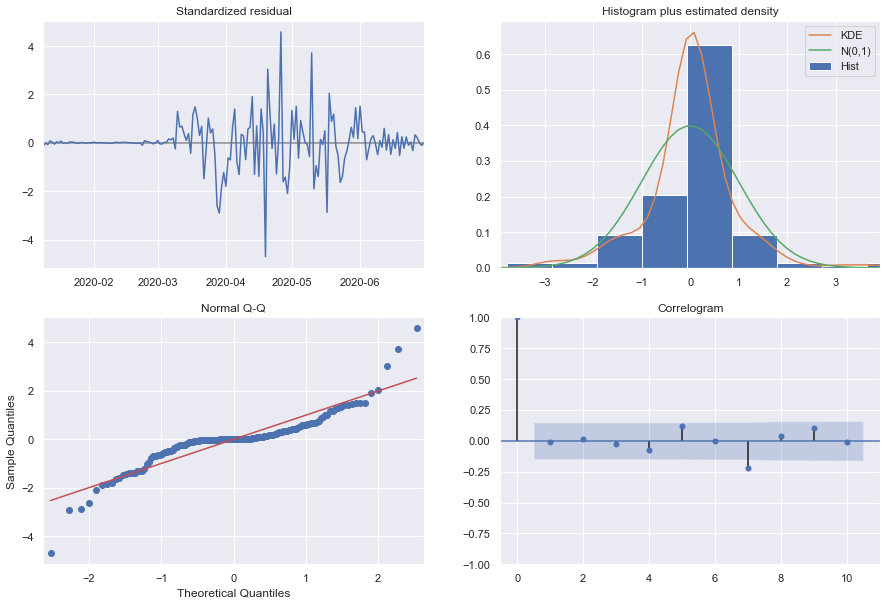

In [158]:
resultsfx.plot_diagnostics(figsize=(15,10))
plt.show()

In [95]:
modelfx = sm.tsa.statespace.SARIMAX(covid_esp_smooth7[7:-12], order=(3,1,2), exog=exogconcat.dropna())
resultsfx = modelfx.fit()
resultsfx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  176
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1065.441
Date:                Sat, 08 Aug 2020   AIC                           2160.882
Time:                        00:09:18   BIC                           2208.354
Sample:                    01-07-2020   HQIC                          2180.138
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
FLT_ARR_1                      -0.8637      0.745     -1.160      0.246      -2.323       0.596
c1_schoolclosing             -607.7783    555.440     -1.094      0.274   -1696.420     480.863
c2_workplaceclosing          -213.5029    395.264     -0.540      0.589    -988.207     561.201
c3_cancelpublicevents        1739.5653    798.904      2.177      0.029     173.742    3305.388
c4_restrictionsongatherings  -230.5842    180.884     -1.275      0.202    -585.110     123.941
c5_closepublictransport      -142.0211   1348.039     -0.105      0.916   -2784.129    2500.087
c6_stayathomerequirements     327.8150    577.779      0.567      0.570    -804.611    1460.241
c7_domestictravel            3077.6088   1661.908      1.852      0.064    -179.672    6334.889
c8_internationaltravel      -1259.6699    560.842     -2.246      0.025   -2358.900    -160.440
ar.L1                           1.4894      0.166      8.954      0.000       1.163       1.815
ar.L2                          -0.9581      0.160     -5.985      0.000      -1.272      -0.644
ar.L3                           0.3752      0.088      4.261      0.000       0.203       0.548
ma.L1                          -1.0790      0.165     -6.538      0.000      -1.402      -0.756
ma.L2                           0.6831      0.100      6.822      0.000       0.487       0.879
sigma2                       1.126e+04    710.688     15.842      0.000    9865.683    1.27e+04
===================================================================================
Ljung-Box (Q):                       52.24   Jarque-Bera (JB):               225.81
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):              49.40   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

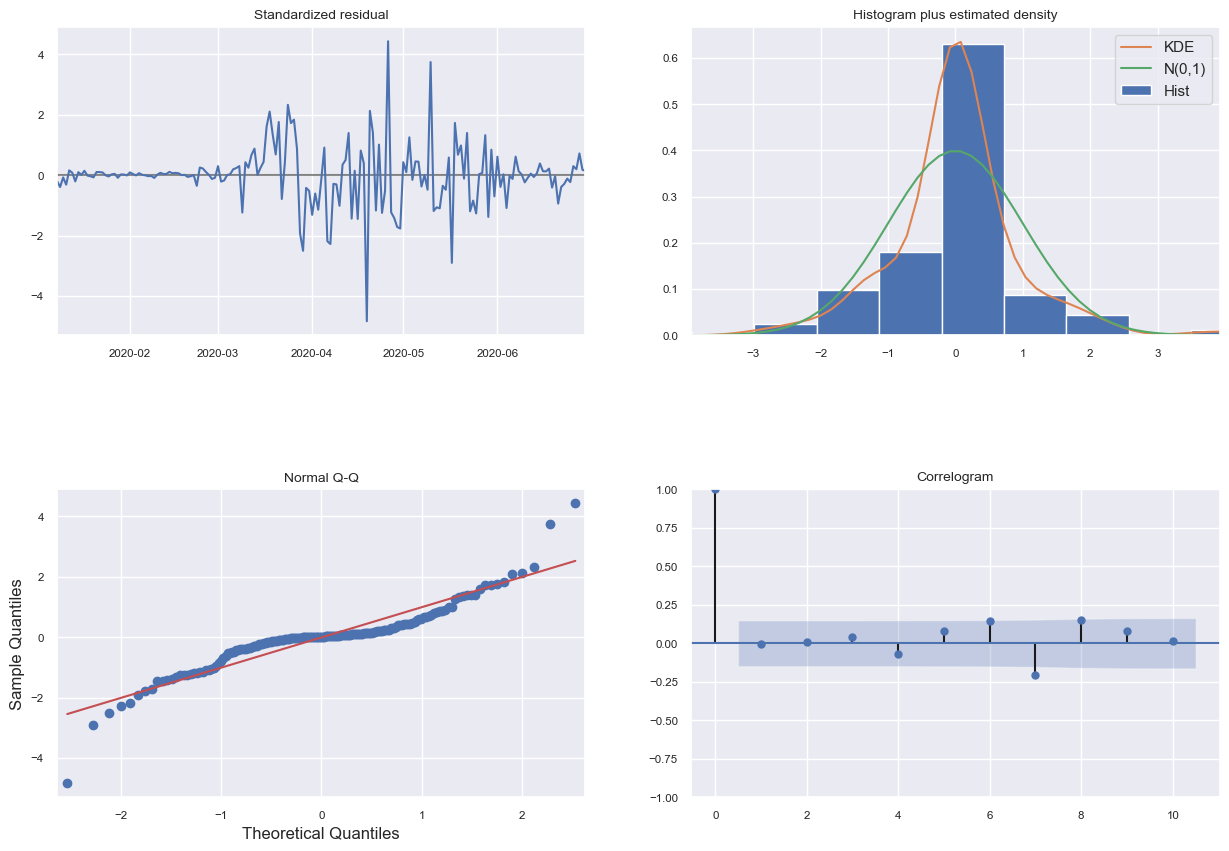

In [96]:
resultsfx.plot_diagnostics(figsize=(15,10))
plt.show()

[541.12387079 566.25372661 505.70704925 509.23653118 347.23073252
 310.9132429  238.42013594 283.53024364 288.92835508 304.86095513
 302.05402372 313.70298255 334.65391974 333.45802083 301.15588402
 324.02341775 330.62964464 343.35156965 382.23515743 337.62678432
 434.99310742 384.11162308 377.50741175 355.89656572 341.73583658
 301.74223441 341.12153855 281.05117044 333.8830655  345.27401948]


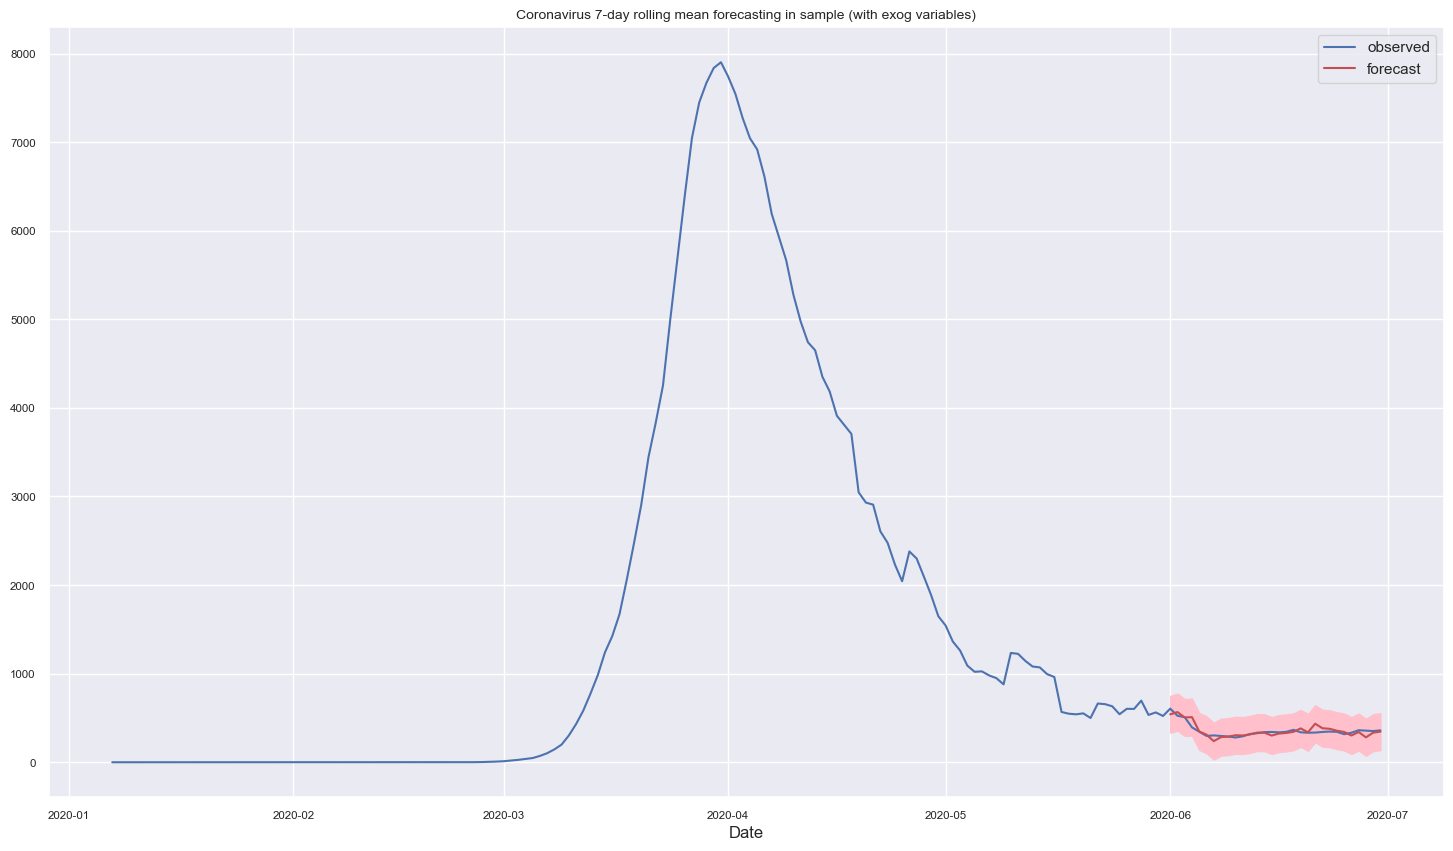

In [99]:
# Generate in sample predictions
one_step_forecast = resultsfx.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(covid_esp_smooth7[7:-12].index, covid_esp_smooth7[7:-12], label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecasting in sample (with exog variables)')
plt.legend()
plt.show()

In [100]:
# REVIEW!!

print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(covid_esp_smooth7[7:-12][-30:], (mean_forecast.values))))
print("Test MAE: %.3f" % np.mean(abs(resultsfx.resid)))

Test RMSE: 40.979
Test MAE: 76.038


In [63]:
print(y[7:-12].shape, X.dropna().shape)

(176, 1) (176, 9)


In [77]:
y[6:-13].tail()

,0
177,0.040098
178,0.042123
179,0.045757
180,0.045160
181,0.044582


In [78]:
X.dropna().tail()

,0,1,2,3,4,5,6,7,8
177,0.164130,0.666667,0.047619,1.0,0.535714,0.0,0.071429,0.142857,0.357143
178,0.179532,0.666667,0.000000,1.0,0.500000,0.0,0.000000,0.000000,0.250000
179,0.188543,0.666667,0.000000,1.0,0.500000,0.0,0.000000,0.000000,0.250000
180,0.190125,0.666667,0.000000,1.0,0.500000,0.0,0.000000,0.000000,0.250000
181,0.191404,0.666667,0.000000,1.0,0.500000,0.0,0.000000,0.000000,0.250000


In [82]:
modelfx = sm.tsa.statespace.SARIMAX(y[6:-13], order=(3,1,2), exog=X.dropna())
resultsfx = modelfx.fit()
resultsfx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      0   No. Observations:                  176
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 500.796
Date:                Sat, 08 Aug 2020   AIC                           -971.592
Time:                        14:42:49   BIC                           -924.121
Sample:                             0   HQIC                          -952.337
                                - 176                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3260      0.202     -1.615      0.106      -0.722       0.070
1             -0.2384      0.132     -1.806      0.071      -0.497       0.020
2             -0.0598      0.193     -0.311      0.756      -0.437       0.318
3              0.3056      0.270      1.130      0.259      -0.225       0.836
4             -0.1399      0.132     -1.062      0.288      -0.398       0.118
5             -0.0112      0.165     -0.068      0.946      -0.334       0.312
6              0.0136      0.136      0.100      0.920      -0.254       0.281
7              0.2861      0.184      1.552      0.121      -0.075       0.648
8             -0.3625      0.335     -1.080      0.280      -1.020       0.295
ar.L1          0.6230      0.712      0.875      0.381      -0.772       2.018
ar.L2          0.0093      0.620      0.015      0.988      -1.206       1.224
ar.L3          0.1960      0.135      1.456      0.145      -0.068       0.460
ma.L1         -0.2220      0.720     -0.308      0.758      -1.634       1.190
ma.L2          0.0969      0.360      0.269      0.788      -0.609       0.803
sigma2         0.0002   1.12e-05     17.101      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       92.06   Jarque-Bera (JB):               364.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              35.81   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

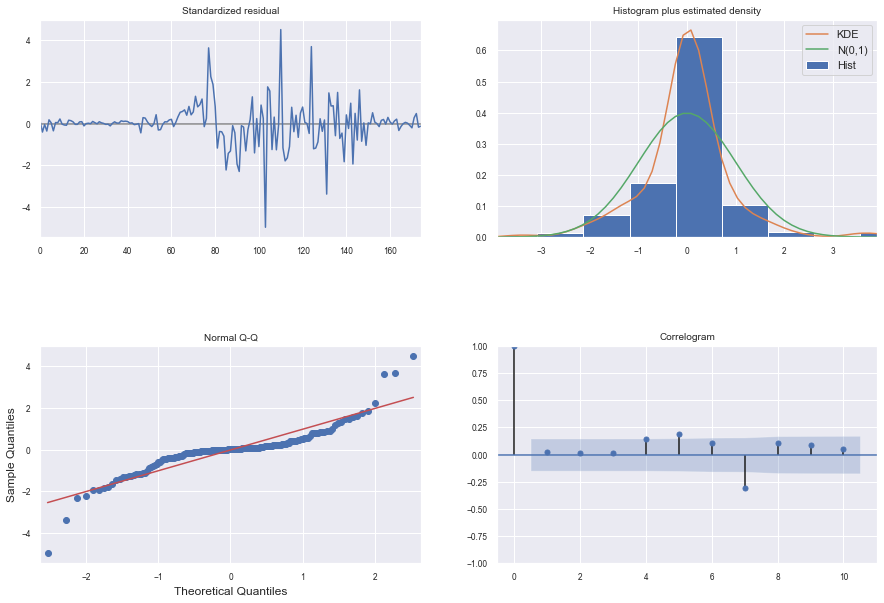

In [81]:
resultsfx.plot_diagnostics(figsize=(15,10))
plt.show()